In [ ]:
!pip install dfllama
!pip install python-louvain
!pip install ipywidgets
!pip install jupyterlab_widgets
!pip install squarify
!pip install pyvis


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 63.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date
import plotly.graph_objects as go
from dfllama import DefiLlamaClient, Coin
import os
import plotly.express as px
import gc  # For garbage collection
import random
from collections import defaultdict
import warnings
from tqdm import tqdm
import requests
import math
from community import community_louvain
import pickle
import squarify
import time
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import spearmanr
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots
from scipy.signal import find_peaks
import json
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import FuncFormatter

In [2]:
def collect_defi_data(use_downloaded=False, data_dir='defi_data'):
    """Collect data from DefiLlama API or read from local files if available"""

    os.makedirs(data_dir, exist_ok=True)

    # File paths
    protocols_path = os.path.join(data_dir, 'protocols.csv')
    dex_path = os.path.join(data_dir, 'dex.csv')
    bridges_path = os.path.join(data_dir, 'bridges.csv')
    tvl_path = os.path.join(data_dir, 'tvl.csv')

    if use_downloaded and all(os.path.exists(p) for p in [protocols_path, dex_path, bridges_path, tvl_path]):
        protocols_df = pd.read_csv(protocols_path)
        dex_df = pd.read_csv(dex_path)
        bridges_df = pd.read_csv(bridges_path)
        tvl_df = pd.read_csv(tvl_path)
    else:
        client = DefiLlamaClient()

        # Fetch and save protocols
        protocols = client.get_protocols()
        protocols_df = pd.DataFrame(protocols)
        protocols_df.to_csv(protocols_path, index=False)

        # Fetch and save DEX volumes
        dex_volumes = client.get_dexes_volume_overview()
        dex_df = pd.DataFrame(dex_volumes['protocols'])
        dex_df.to_csv(dex_path, index=False)

        # Fetch and save bridges
        bridges = client.get_bridges()
        bridges_df = pd.DataFrame(bridges)
        bridges_df.to_csv(bridges_path, index=False)

        # Fetch and save TVL history
        tvl_history = client.get_historical_tvl_of_defi_on_all_chains()
        tvl_df = pd.DataFrame(tvl_history)
        tvl_df.to_csv(tvl_path, index=False)

    return protocols_df, dex_df, bridges_df, tvl_df

protocols_df, dex_df, bridges_df, tvl_df = collect_defi_data(use_downloaded=True)

In [5]:
# Set visualization styles
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display basic information about each dataframe
def explore_dataframe(df, name):
    print(f"\n### {name} Overview ###")
    print(f"Shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    print("\nSample data:")
    print(df.head(2))
    print("\nData types:")
    print(df.dtypes)
    print("\nMissing values:")
    print(df.isnull().sum())

# Explore all dataframes
explore_dataframe(protocols_df, "Protocols")
explore_dataframe(dex_df, "DEX Volumes")
explore_dataframe(bridges_df, "Bridges")
explore_dataframe(tvl_df, "TVL History")


### Protocols Overview ###
Shape: (5741, 51)
Columns: ['id', 'name', 'address', 'symbol', 'url', 'description', 'chain', 'logo', 'audits', 'audit_note', 'gecko_id', 'cmcId', 'category', 'chains', 'module', 'twitter', 'forkedFrom', 'oracles', 'listedAt', 'methodology', 'slug', 'tvl', 'chainTvls', 'change_1h', 'change_1d', 'change_7d', 'tokenBreakdowns', 'mcap', 'audit_links', 'parentProtocol', 'wrongLiquidity', 'hallmarks', 'github', 'referralUrl', 'treasury', 'openSource', 'governanceID', 'staking', 'previousNames', 'tokensExcludedFromParent', 'assetToken', 'oraclesByChain', 'pool2', 'stablecoins', 'misrepresentedTokens', 'oraclesBreakdown', 'language', 'deadUrl', 'deadFrom', 'rugged', 'deprecated']

Sample data:
     id         name address symbol                      url  \
0  2269  Binance CEX     NaN      -  https://www.binance.com   
1  2272          OKX     NaN      -      https://www.okx.com   

                                         description        chain  \
0  Binance is 

In [11]:
# 1. Protocols Analysis
def analyze_protocols(df, include_cex=True, analysis_dir="analysis"):
    """
    Analyze protocol data with option to include or exclude CEX protocols

    Parameters:
    df: DataFrame containing protocol data
    include_cex: Boolean - whether to include CEX protocols in analysis (default: True)
    analysis_dir: Directory where to save analysis outputs (default: "analysis")
    """
    print("\n=== PROTOCOL ANALYSIS ===")
    cex_status = "including CEX" if include_cex else "excluding CEX"
    print(f"Analysis parameters: {cex_status}")

    # Only load essential columns to reduce memory usage
    essential_columns = ['name', 'tvl', 'category', 'chains']
    df_slim = df[essential_columns].copy()

    # Handle missing values
    df_slim = df_slim.dropna(subset=['tvl'])

    # Filter out CEX protocols if include_cex is False
    if not include_cex:
        df_slim = df_slim[df_slim['category'] != 'CEX']
        print(f"Filtered out CEX protocols. Analyzing {len(df_slim)} protocols.")

    # 1.1 TVL Distribution by Category
    print("\nTop 10 Protocols by TVL:")
    # Use nlargest instead of sorting the entire dataframe
    top_protocols = df_slim.nlargest(10, 'tvl')
    print(top_protocols[['name', 'tvl', 'category']])

    # 1.2 Category Distribution
    # Group by category efficiently
    category_tvl = df_slim.groupby('category')['tvl'].sum().nlargest(10)
    print("\nTVL by Category:")
    print(category_tvl)

    # Calculate total TVL
    total_tvl = df_slim['tvl'].sum()
    print(f"\nTotal TVL ({cex_status}): ${total_tvl/1e9:.2f} Billion USD")

    # 1.3 Chain Distribution
    # Process chains more efficiently
    if 'chains' in df_slim.columns:
        # Sample only 1000 protocols for chain analysis to reduce memory usage
        sample_size = min(1000, len(df_slim))
        chains_sample = df_slim.sample(sample_size)

        # Convert chain strings to lists if they're stored as strings
        if isinstance(chains_sample['chains'].iloc[0], str):
            chains_sample['chains'] = chains_sample['chains'].apply(
                lambda x: x.strip('[]').replace("'", "").split(', ') if isinstance(x, str) else []
            )

        # Process one row at a time instead of using explode (which duplicates data)
        chain_counts = {}
        for chains_list in chains_sample['chains']:
            if isinstance(chains_list, list):
                for chain in chains_list:
                    chain_counts[chain] = chain_counts.get(chain, 0) + 1

        # Convert to series for easier display
        chain_series = pd.Series(chain_counts).nlargest(10)
        print("\nTop 10 Chains by Protocol Count (sampled):")
        print(chain_series)

    # 1.4 Visualizations - Create them separately to reduce memory usage

    # Add CEX status to filenames
    filename_suffix = "_with_cex" if include_cex else "_no_cex"

    # Plot 1: Top 10 protocols by TVL
    plt.figure(figsize=(10, 6))
    ax1 = sns.barplot(x=top_protocols.tvl/1_000_000_000, y=top_protocols.name)

    # Annotate each bar with the actual value
    for container in ax1.containers:
        ax1.bar_label(container, fmt='%.2f')  # Display with two decimal places

    plt.title(f'Top 10 Protocols by TVL ({cex_status})')
    plt.xlabel('TVL (Billion USD)')
    plt.tight_layout()
    plt.savefig(f'{analysis_dir}/protocol_tvl_top10{filename_suffix}.png')
    plt.close()  # Close figure to free memory

    # Plot 2: TVL by category
    plt.figure(figsize=(10, 6))
    ax2 = sns.barplot(x=category_tvl.values/1_000_000_000, y=category_tvl.index)

    # Annotate each bar with the actual value
    for container in ax2.containers:
        ax2.bar_label(container, fmt='%.2f')  # Display with two decimal places

    plt.title(f'TVL by Category ({cex_status})')
    plt.xlabel('TVL (Billion USD)')
    plt.tight_layout()
    plt.savefig(f'{analysis_dir}/protocol_tvl_by_category{filename_suffix}.png')
    plt.close()

    # Free memory by deleting no longer needed objects
    del df_slim
    gc.collect()

    # Plot 3: Protocols per Chain
    if 'chains' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.barplot(x=chain_series.values, y=chain_series.index)
        plt.title(f'Top Chains by Protocol Count ({cex_status}, sampled)')
        plt.xlabel('Number of Protocols')
        plt.tight_layout()
        plt.savefig(f'{analysis_dir}/protocol_chains{filename_suffix}.png')
        plt.close()

    # Create a simplified Plotly treemap with fewer items
    top_categories = category_tvl.head(10).index.tolist()
    filtered_df = df[df['category'].isin(top_categories)].copy()

    # Apply CEX filtering to treemap data if needed
    if not include_cex:
        filtered_df = filtered_df[filtered_df['category'] != 'CEX']

    # Take top protocols by TVL
    filtered_df = filtered_df.nlargest(50, 'tvl')

    fig = px.treemap(
        filtered_df,
        path=['category', 'name'],
        values='tvl',
        title=f'TVL Distribution by Category and Protocol ({cex_status})',
        hover_data=['tvl']
    )
    fig.write_html(f'{analysis_dir}/protocol_treemap{filename_suffix}.html')

    return f"Protocol analysis completed ({cex_status}). See visualizations in separate PNG files and protocol_treemap{filename_suffix}.html"

# Standard analysis with CEX included
analyze_protocols(protocols_df)

# Analysis excluding CEX
analyze_protocols(protocols_df, include_cex=False)


=== PROTOCOL ANALYSIS ===
Analysis parameters: including CEX

Top 10 Protocols by TVL:
          name           tvl        category
0  Binance CEX  1.241301e+11             CEX
1          OKX  2.108780e+10             CEX
2     Bitfinex  2.065341e+10             CEX
3      AAVE V3  1.620953e+10         Lending
4        Bybit  1.438583e+10             CEX
5    Robinhood  1.385817e+10             CEX
6         Lido  1.381504e+10  Liquid Staking
7         WBTC  9.969247e+09          Bridge
8   EigenLayer  6.863084e+09       Restaking
9  Sky Lending  6.494997e+09             CDP

TVL by Category:
category
CEX               2.347626e+11
Lending           3.695806e+10
Bridge            3.236617e+10
Liquid Staking    2.965638e+10
Chain             1.786472e+10
Dexs              1.642989e+10
Restaking         1.357577e+10
RWA               1.060476e+10
CDP               9.507429e+09
Yield             8.458560e+09
Name: tvl, dtype: float64

Total TVL (including CEX): $449.75 Billion USD

Top 1

'Protocol analysis completed (excluding CEX). See visualizations in separate PNG files and protocol_treemap_no_cex.html'

In [ ]:
# 2. DEX Volumes Analysis
def analyze_dexes(df, analysis_dir='analysis'):
    print("\n=== DEX ANALYSIS ===")

    # Based on the dataset statistics, we need to use the correct column names
    # The dataset has columns like 'total24h', 'total30d', etc. instead of 'totalVolume'

    # 2.1 Top DEXes by Volume (using total24h as the primary metric)
    print("\nTop 10 DEXes by 24h Volume:")
    if 'total24h' in df.columns:
        # Create a copy with just the needed columns to reduce memory usage
        top_dexes = df[['name', 'displayName', 'total24h']].copy()
        top_dexes = top_dexes.dropna(subset=['total24h']).nlargest(10, 'total24h')
        print(top_dexes[['name', 'total24h']])

        # Print some additional volume metrics
        print("\nVolume metrics for top DEXes:")
        if 'total7d' in df.columns and 'total30d' in df.columns:
            metrics_df = df.loc[top_dexes.index][['name', 'total24h', 'total7d', 'total30d']].dropna()
            if not metrics_df.empty:
                print(metrics_df)
    else:
        print("No 'total24h' column found in the dataset")

    # 2.2 DEXes by Chain
    # Based on dataset info, 'chains' contains lists of chains, not a single chain value
    if 'chains' in df.columns:
        print("\nTop chains by DEX presence:")

        # Process chains more efficiently - sample if dataset is large
        sample_size = min(200, len(df))
        chains_sample = df.sample(sample_size) if len(df) > sample_size else df

        # Handle chains list properly
        chain_counts = {}
        chain_volumes = {}

        # Process one row at a time
        for idx, row in chains_sample.iterrows():
            chains = row['chains']
            volume = row.get('total24h', 0)

            # Convert to list if it's a string representation
            if isinstance(chains, str):
                chains = eval(chains) if chains.startswith('[') else [chains]

            # Count appearances and sum volumes
            if isinstance(chains, list):
                for chain in chains:
                    chain_counts[chain] = chain_counts.get(chain, 0) + 1
                    if pd.notna(volume):
                        chain_volumes[chain] = chain_volumes.get(chain, 0) + volume

        # Convert to series for easier display
        chain_series = pd.Series(chain_counts).nlargest(10)
        print("Chain popularity (number of DEXes):")
        print(chain_series)

        if chain_volumes:
            volume_series = pd.Series(chain_volumes).nlargest(10)
            print("\nChain volume (24h):")
            print(volume_series)

    # 2.3 Visualizations
    plt.figure(figsize=(12, 6))

    # Top DEXes by volume
    if 'total24h' in df.columns and not top_dexes.empty:
        sns.barplot(x='total24h', y='name', data=top_dexes)
        plt.title('Top 10 DEXes by 24h Volume')
        plt.xlabel('24h Volume (USD)')
        plt.ticklabel_format(style='plain', axis='x')
        plt.tight_layout()
        plt.savefig(f'{analysis_dir}/dex_volume_top10.png')
        plt.close()  # Close to free memory

    # Volume by chain as a separate chart
    if chain_volumes:
        plt.figure(figsize=(12, 6))
        chain_vol_df = pd.DataFrame({
            'chain': volume_series.index,
            'volume': volume_series.values
        })
        sns.barplot(x='volume', y='chain', data=chain_vol_df)
        plt.title('Volume by Chain (24h)')
        plt.xlabel('Volume (USD)')
        plt.ticklabel_format(style='plain', axis='x')
        plt.tight_layout()
        plt.savefig(f'{analysis_dir}/dex_volume_by_chain.png')
        plt.close()

    # Create a pie chart of market share
    if 'total24h' in df.columns:
        volume_df = df[['name', 'total24h']].dropna().copy()
        if not volume_df.empty:
            top_n = 10
            top_dexes = volume_df.nlargest(top_n, 'total24h')

            # Calculate others volume
            others_volume = volume_df[~volume_df.index.isin(top_dexes.index)]['total24h'].sum()

            # Create a new dataframe with the "Others" category
            pie_df = pd.DataFrame({
                'name': list(top_dexes['name']) + ['Others'],
                'volume': list(top_dexes['total24h']) + [others_volume]
            })

            fig = px.pie(
                pie_df,
                values='volume',
                names='name',
                title='DEX Market Share by 24h Volume'
            )
            fig.write_html(f'{analysis_dir}/dex_market_share.html')

    # Free memory
    gc.collect()

    return "DEX analysis completed. See visualizations in dex_volume_top10.png, dex_volume_by_chain.png, and dex_market_share.html"

# To execute:
analyze_dexes(dex_df)


=== DEX ANALYSIS ===

Top 10 DEXes by 24h Volume:
                     name      total24h
241            Uniswap V3  2.936810e+09
322    PancakeSwap AMM V3  7.567479e+08
0               Curve DEX  6.105539e+08
526  Aerodrome Slipstream  5.411215e+08
18                   Orca  5.124146e+08
622             Fluid DEX  4.171299e+08
489          Meteora DLMM  4.071526e+08
11            Raydium AMM  3.507992e+08
233           Lifinity V1  3.190276e+08
9         PancakeSwap AMM  3.071920e+08

Volume metrics for top DEXes:
                     name      total24h       total7d      total30d
241            Uniswap V3  2.936810e+09  1.220644e+10  4.193045e+10
322    PancakeSwap AMM V3  7.567479e+08  3.295490e+09  1.683326e+10
0               Curve DEX  6.105539e+08  1.814234e+09  7.402397e+09
526  Aerodrome Slipstream  5.411215e+08  2.343389e+09  7.205778e+09
18                   Orca  5.124146e+08  3.596454e+09  1.157345e+10
622             Fluid DEX  4.171299e+08  2.804955e+09  1.062087e+10
48

'DEX analysis completed. See visualizations in dex_volume_top10.png, dex_volume_by_chain.png, and dex_market_share.html'


=== BRIDGES ANALYSIS ===

Top 10 Bridges by Daily Volume:
          name  lastDailyVolume
0    layerzero     3.731014e+08
1     stargate     1.731122e+08
2       circle     1.485794e+08
3  hyperliquid     6.795242e+07
4        meson     5.167774e+07
5     wormhole     4.118930e+07
6          ibc     2.648543e+07
7       across     2.475240e+07
8  debridgedln     1.308258e+07
9         xdai     1.266093e+07


'Bridge analysis completed. See visualizations in bridge_analysis.png and bridge_chains_support.html'

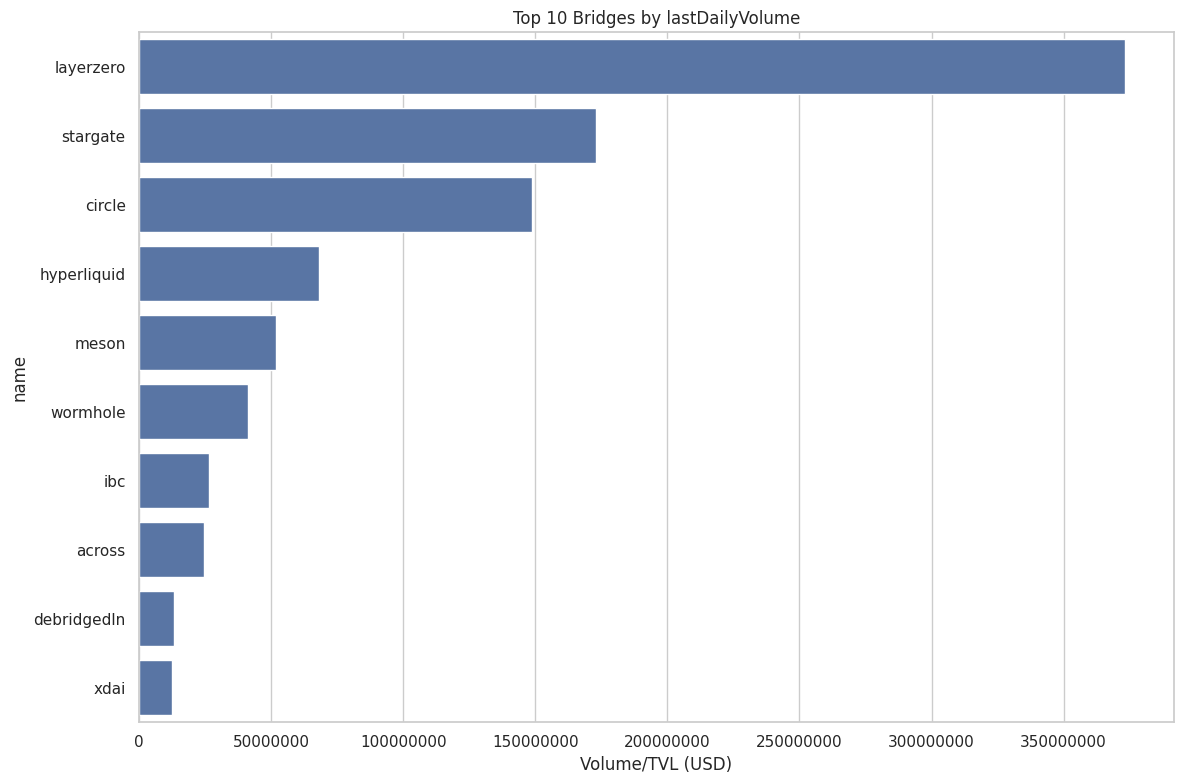

In [11]:
# 3. Bridges Analysis
def analyze_bridges(df, analysis_dir="analysis"):
    print("\n=== BRIDGES ANALYSIS ===")

    # 3.1 Top Bridges by Volume or TVL
    if 'lastDailyVolume' in df.columns:
        top_bridges = df.sort_values('lastDailyVolume', ascending=False).head(10)
        print("\nTop 10 Bridges by Daily Volume:")
        print(top_bridges[['name', 'lastDailyVolume']])
    elif 'volume' in df.columns:
        top_bridges = df.sort_values('volume', ascending=False).head(10)
        print("\nTop 10 Bridges by Volume:")
        print(top_bridges[['name', 'volume']])
    elif 'tvl' in df.columns:
        top_bridges = df.sort_values('tvl', ascending=False).head(10)
        print("\nTop 10 Bridges by TVL:")
        print(top_bridges[['name', 'tvl']])

    # 3.2 Visualizations
    fig, ax = plt.subplots(figsize=(12, 8))

    # Determine which column to use for sorting
    volume_col = None
    for col in ['lastDailyVolume', 'volume', 'tvl']:
        if col in df.columns:
            volume_col = col
            break

    if volume_col:
        top_for_viz = df.sort_values(volume_col, ascending=False).head(10)
        sns.barplot(x=volume_col, y='name', data=top_for_viz, ax=ax)
        ax.set_title(f'Top 10 Bridges by {volume_col}')
        ax.set_xlabel('Volume/TVL (USD)')
        ax.ticklabel_format(style='plain', axis='x')

    plt.tight_layout()
    plt.savefig(f'{analysis_dir}/bridge_analysis.png')

    # Create a visualization of bridge destinations if data available
    if 'chains' in df.columns:
        try:
            # Assuming chains column contains lists of supported chains
            chains_df = df.explode('chains')
            chain_counts = chains_df['chains'].value_counts().head(10)

            fig = px.bar(
                x=chain_counts.values,
                y=chain_counts.index,
                orientation='h',
                title='Top Chains Supported by Bridges',
                labels={'x': 'Number of Bridges', 'y': 'Chain'}
            )
            fig.write_html(f'{analysis_dir}/bridge_chains_support.html')
        except:
            pass

    return "Bridge analysis completed. See visualizations in bridge_analysis.png and bridge_chains_support.html"

analyze_bridges(bridges_df)



=== TVL HISTORY ANALYSIS ===

TVL Statistics:
count    2.540000e+03
mean     5.084996e+10
std      4.926091e+10
min      2.423010e+05
25%      6.057074e+08
50%      4.543223e+10
75%      8.670668e+10
max      1.788605e+11
Name: tvl, dtype: float64

Date range after correction: 2018-04-27 00:00:00 to 2025-04-09 00:00:00


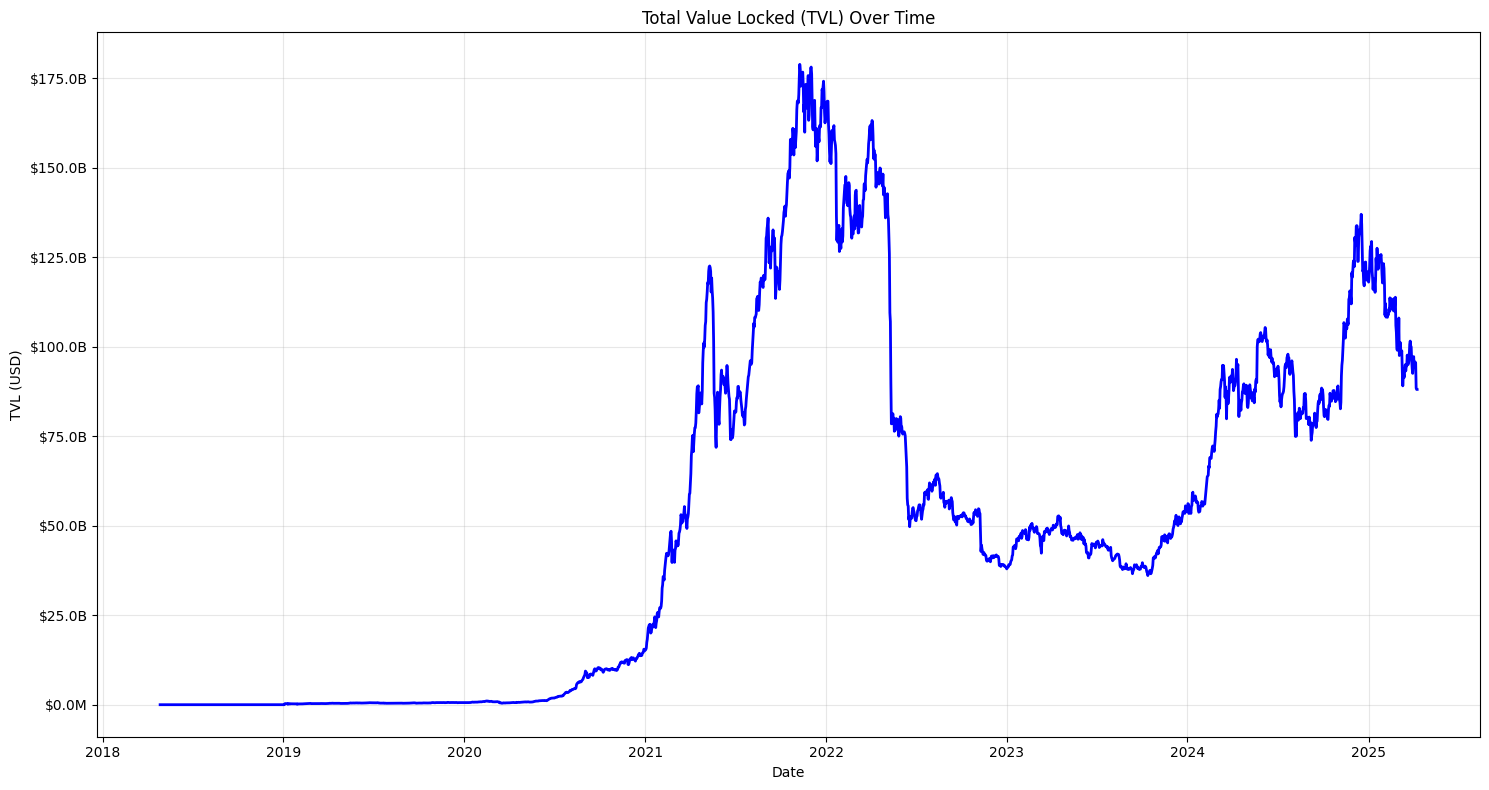


Top 8 local maxima in TVL:
1. Date: 2021-11-09, TVL: $178,860,511,989.00
2. Date: 2021-12-27, TVL: $174,156,034,828.00
3. Date: 2022-04-04, TVL: $163,176,483,047.00
4. Date: 2022-02-10, TVL: $147,553,101,108.00
5. Date: 2024-12-17, TVL: $136,984,289,463.00
6. Date: 2021-09-06, TVL: $135,917,612,348.00
7. Date: 2025-01-18, TVL: $127,502,976,722.00
8. Date: 2021-05-11, TVL: $122,548,582,774.00


'TVL history analysis completed with top 8 local maxima identified.'

In [ ]:
def analyze_tvl_history(df, analysis_dir='analysis'):
    print("\n=== TVL HISTORY ANALYSIS ===")

    # Create directory if it doesn't exist
    os.makedirs(analysis_dir, exist_ok=True)

    # Create a copy and reset the date column based on the original integer values
    analysis_df = df.copy()

    # Print basic statistics
    print("\nTVL Statistics:")
    print(analysis_df['tvl'].describe())

    # Extract original timestamp values and verify they look reasonable
    # Since we're looking at DeFi data, timestamps should be between 2017-2025

    # Method 1: If integer values were preserved but parsed as timestamps
    if isinstance(analysis_df['date'].iloc[0], pd.Timestamp):
        print("\nRetrieving original timestamp integers...")
        # First try: convert the timestamps back to integer nanoseconds, then to seconds
        original_seconds = analysis_df['date'].astype('int64') // 10**9
        print(f"Sample timestamp integers: {original_seconds.head().tolist()}")
    else:
        # If they're already integers, just use them directly
        original_seconds = analysis_df['date']

    # If values are too small (less than year ~2000), they might not be Unix timestamps
    if original_seconds.max() < 946684800:  # Jan 1, 2000
        print("WARNING: Timestamp values appear to be too small for Unix timestamps in seconds.")
        # Try to read the dates from scratch
        # For this specific case, create your own timestamps based on the index
        # Assuming data starts from April 26, 2018 (1524787200) with daily intervals
        base_timestamp = 1524787200
        analysis_df['datetime'] = pd.to_datetime(
            [base_timestamp + i*86400 for i in range(len(analysis_df))],
            unit='s'
        )
    else:
        # Convert to proper datetime
        analysis_df['datetime'] = pd.to_datetime(original_seconds, unit='s')

    # Sort by date
    analysis_df = analysis_df.sort_values(by='datetime')

    # Print the resulting date range
    print(f"\nDate range after correction: {analysis_df['datetime'].min()} to {analysis_df['datetime'].max()}")

    # 4.3 Time Series Visualization with Matplotlib
    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(analysis_df['datetime'], analysis_df['tvl'], 'b-', linewidth=2)
    ax.set_title('Total Value Locked (TVL) Over Time')
    ax.set_xlabel('Date')
    ax.set_ylabel('TVL (USD)')
    ax.grid(True, alpha=0.3)

    # Format y-axis labels
    from matplotlib.ticker import FuncFormatter
    def billions(x, pos):
        return f'${x/1e9:.1f}B' if x >= 1e9 else f'${x/1e6:.1f}M'
    ax.yaxis.set_major_formatter(FuncFormatter(billions))

    plt.tight_layout()
    plt.savefig(f'{analysis_dir}/tvl_history.png')
    plt.show()
    plt.close()


    # Use SciPy's find_peaks with appropriate parameters
    # Adjust the prominence and distance parameters to filter significant peaks
    tvl_array = analysis_df['tvl'].values
    peaks, _ = find_peaks(tvl_array, prominence=0.05*np.max(tvl_array), distance=30)

    # Create a dataframe of peaks
    peak_data = pd.DataFrame({
        'datetime': analysis_df['datetime'].iloc[peaks],
        'tvl': analysis_df['tvl'].iloc[peaks],
        'index': peaks
    })

    # Sort peaks by TVL value to get top 8
    top_peaks = peak_data.sort_values('tvl', ascending=False).head(8)
    print("\nTop 8 local maxima in TVL:")
    for i, (_, peak) in enumerate(top_peaks.iterrows(), 1):
        print(f"{i}. Date: {peak['datetime'].strftime('%Y-%m-%d')}, TVL: ${peak['tvl']:,.2f}")

    # 4.5 Create enhanced TVL plot with Plotly showing top peaks
    plot_df = analysis_df

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    # Main TVL line
    fig.add_trace(
        go.Scatter(
            x=plot_df['datetime'],
            y=plot_df['tvl'],
            name="Total TVL",
            line=dict(color='royalblue', width=2)
        ),
        secondary_y=False
    )


    # Add markers for top 5 peaks with TVL amount as text
    fig.add_trace(
        go.Scatter(
            x=top_peaks['datetime'],
            y=top_peaks['tvl'],
            mode='markers+text',
            marker=dict(
                size=12,
                color='green',
                symbol='star',
                line=dict(width=2, color='black')
            ),
            # Format TVL amount for display - showing in billions or millions as appropriate
            text=[f"${tvl/1e9:.2f}B" if tvl >= 1e9 else f"${tvl/1e6:.1f}M" for tvl in top_peaks['tvl']],
            textposition="top center",
            name="Top 8 Local Maxima",
            textfont=dict(size=14, color='black')
        ),
        secondary_y=False
    )

    fig.update_layout(
        title_text="TVL and 90-Day Average Growth Rate with Top 8 Local Maxima",
        xaxis_title="Date",
        legend=dict(y=1.1, x=0.5, xanchor="center", orientation="h")
    )

    fig.update_yaxes(title_text="TVL (USD)", secondary_y=False)
    fig.update_yaxes(title_text="Growth Rate (%)", secondary_y=True, tickformat=".0f%")

    fig.write_html(f'{analysis_dir}/tvl_growth_analysis.html')

    # Create a standalone plot focusing on just the top peaks
    fig_peaks = go.Figure()

    # Add TVL line
    fig_peaks.add_trace(
        go.Scatter(
            x=analysis_df['datetime'],
            y=analysis_df['tvl'],
            name="TVL",
            line=dict(color='royalblue', width=2)
        )
    )

    # Add markers for all identified peaks
    fig_peaks.add_trace(
        go.Scatter(
            x=peak_data['datetime'],
            y=peak_data['tvl'],
            mode='markers',
            marker=dict(size=8, color='gray'),
            name="All Local Maxima"
        )
    )

    # Add highlighted markers for top 5 peaks with TVL amount as text
    for i, (_, peak) in enumerate(top_peaks.iterrows()):
        tvl_formatted = f"${peak['tvl']/1e9:.2f}B" if peak['tvl'] >= 1e9 else f"${peak['tvl']/1e6:.1f}M"
        fig_peaks.add_trace(
            go.Scatter(
                x=[peak['datetime']],
                y=[peak['tvl']],
                mode='markers+text',
                marker=dict(
                    size=14,
                    color='green',
                    symbol='star',
                    line=dict(width=2, color='black')
                ),
                text=tvl_formatted,
                textposition="top center",
                name=f"Peak #{i+1}",
                showlegend=False
            )
        )


    fig_peaks.update_layout(
        title_text="Top 8 Local Maxima in TVL History",
        xaxis_title="Date",
        yaxis_title="TVL (USD)",
        hovermode="x unified"
    )

    # Add a ranking table as annotations
    table_text = "Rank | Date | TVL<br>"
    for i, (_, peak) in enumerate(top_peaks.iterrows(), 1):
        tvl_formatted = f"${peak['tvl']/1e9:.2f}B" if peak['tvl'] >= 1e9 else f"${peak['tvl']/1e6:.1f}M"
        table_text += f"{i} | {peak['datetime'].strftime('%Y-%m-%d')} | {tvl_formatted}<br>"

    fig_peaks.add_annotation(
        xref="paper", yref="paper",
        x=0.01, y=0.98,
        text=table_text,
        showarrow=False,
        font=dict(family="Courier New, monospace", size=12),
        align="left",
        bgcolor="rgba(255, 255, 255, 0.8)",
        bordercolor="black",
        borderwidth=1,
        borderpad=4
    )

    fig_peaks.write_html(f'{analysis_dir}/tvl_top_peaks.html')

    return "TVL history analysis completed with top 8 local maxima identified."

analyze_tvl_history(tvl_df)

In [3]:
def preprocess_data(protocols_df, dex_df, bridges_df):
    """Preprocess collected data for network analysis"""
    # Clean protocols data
    clean_protocols = protocols_df[['name', 'slug', 'tvl', 'chain', 'chains', 'category']].copy()
    # Fill missing chain with "Unknown" instead of dropping
    clean_protocols['chain'] = clean_protocols['chain'].fillna("Unknown")
    # Option 1: Drop only rows without slug (none are missing)
    clean_protocols.dropna(subset=['slug'], inplace=True)
    # Option 2: Fill missing TVL with 0 or median instead of dropping
    clean_protocols['tvl'] = clean_protocols['tvl'].fillna(clean_protocols['tvl'].median())

    # Ensure chains is always a list
    if 'chains' in clean_protocols.columns:
        clean_protocols['chains'] = clean_protocols['chains'].apply(
            lambda x: x if isinstance(x, list) else
                     (eval(x) if isinstance(x, str) and x.startswith('[') else [x])
        )

    # Clean DEX data
    clean_dexes = dex_df[['name', 'chains', 'total24h', 'total7d', 'total30d']].copy()
    # Fill missing volume data with 0
    volume_cols = ['total24h', 'total7d', 'total30d']
    for col in volume_cols:
        clean_dexes[col] = clean_dexes[col].fillna(0)

    # Ensure chains is always a list for DEXes
    clean_dexes['chains'] = clean_dexes['chains'].apply(
        lambda x: x if isinstance(x, list) else
                 (eval(x) if isinstance(x, str) and x.startswith('[') else [x])
    )

    # Clean bridges data - all data is complete, just ensure chains format consistency
    clean_bridges = bridges_df[['name', 'displayName', 'chains', 'volumePrevDay', 'weeklyVolume']].copy()
    clean_bridges['chains'] = clean_bridges['chains'].apply(
        lambda x: x if isinstance(x, list) else
                 (eval(x) if isinstance(x, str) and x.startswith('[') else [x])
    )

    return clean_protocols, clean_dexes, clean_bridges

clean_protocols, clean_dexes, clean_bridges = preprocess_data(protocols_df, dex_df, bridges_df)

In [ ]:
def create_tvl_correlation_matrix(protocol_df,
                                        output_dir='./defi_data/',
                                        start_date=None, end_date=None,
                                        correlation_threshold=0.5, min_data_points=10):
    """
    Create DeFi Corr. Matrix based on historical TVL correlation between protocols.
    """

    print("Building correlation-based DeFi network...")

    # Initialize graph
    G = nx.Graph()  # Undirected graph for correlation relationships

    # Set default dates if not provided
    if not start_date:
        start_date = datetime.now() - timedelta(days=365)
    if not end_date:
        end_date = datetime.now()

    print(f"Using historical data from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

    # STEP 1: Create nodes from protocol data
    print("Creating protocol nodes...")
    protocol_count = 0
    dex_count = 0
    bridge_count = 0

    # Create a mapping from node ID to protocol slug
    node_to_slug = {}

    # Track protocols by category
    protocols_by_category = {}

    # Process main protocol dataset
    for i, row in protocol_df.iterrows():
        try:
            # Skip rows without name
            if 'name' not in row:
                continue

            name_value = row['name']
            if isinstance(name_value, float) and math.isnan(name_value):
                continue

            name = str(name_value)

            # Extract slug - CRITICAL for historical data
            slug = None
            if 'slug' in row:
                slug_value = row['slug']
                if isinstance(slug_value, str) and slug_value.strip():
                    slug = slug_value.strip()

            # Create node ID using slug if available
            if slug:
                node_id = slug  # Use slug as node ID
                node_to_slug[node_id] = slug  # Important: map node ID to slug
            else:
                node_id = f"protocol_{i}"

            # Extract category
            category = 'Unknown'
            if 'category' in row:
                cat_value = row['category']
                if not (isinstance(cat_value, float) and math.isnan(cat_value)):
                    category = str(cat_value)

            # Determine if DEX or bridge based on category
            is_dex = 'dex' in category.lower()
            is_bridge = any(term in category.lower() for term in ['bridge', 'cross-chain', 'multichain'])

            # Extract TVL
            tvl = 0
            try:
                if 'tvl' in row:
                    tvl_value = row['tvl']
                    if not (isinstance(tvl_value, float) and math.isnan(tvl_value)):
                        tvl = float(tvl_value)
            except:
                pass

            # Extract chains
            chains = []
            if 'chains' in row:
                chains_value = row['chains']

                if isinstance(chains_value, list):
                    chains = [str(c).lower() for c in chains_value if c and str(c).strip()]
                elif isinstance(chains_value, str):
                    chains = [chains_value.lower().strip()]
                elif not (isinstance(chains_value, float) and math.isnan(chains_value)):
                    chains = [str(chains_value).lower().strip()]

            # Add node to graph
            G.add_node(
                node_id,
                name=name,
                slug=slug,  # Store slug as attribute
                category=category,
                tvl=tvl,
                chains=chains,
                is_dex=is_dex,
                is_bridge=is_bridge
            )

            # Update category tracking
            if category not in protocols_by_category:
                protocols_by_category[category] = []
            protocols_by_category[category].append(node_id)

            # Update type counts
            if is_dex:
                dex_count += 1
            elif is_bridge:
                bridge_count += 1
            else:
                protocol_count += 1

        except Exception as e:
            print(f"Error processing protocol {i}: {e}")

    # Print network composition
    total_nodes = G.number_of_nodes()
    print(f"\nNetwork composition:")
    print(f"  - Total nodes: {total_nodes}")
    print(f"  - Standard protocols: {protocol_count}")
    print(f"  - DEX protocols: {dex_count}")
    print(f"  - Bridge protocols: {bridge_count}")

    # Top categories
    category_counts = [(cat, len(protocols)) for cat, protocols in protocols_by_category.items()]
    category_counts.sort(key=lambda x: x[1], reverse=True)
    print("\nTop protocol categories:")
    for category, count in category_counts[:10]:
        print(f"  - {category}: {count} protocols")

    # STEP 2: Collect historical TVL data for all protocols
    print("\nCollecting historical TVL data...")

    # Get protocol slugs - FIXED: Extract from node attributes
    protocol_slugs = []
    for node, attrs in G.nodes(data=True):
        if 'slug' in attrs and attrs['slug']:  # Check for slug in attributes
            protocol_slugs.append(attrs['slug'])

    print(f"Fetching historical data for {len(protocol_slugs)} protocols...")

    # Convert dates to Unix timestamps
    start_timestamp = int(start_date.timestamp())
    end_timestamp = int(end_date.timestamp())

    # Initialize DataFrame for historical TVL data
    historical_tvl_data = {}

    # Define window for rate limiting
    api_calls = 0
    batch_size = 500
    max_calls_per_minute = 200  # More conservative rate limiting

    # Fetch data in batches with rate limiting
    for i in range(0, len(protocol_slugs), batch_size):
        batch_slugs = protocol_slugs[i:i+batch_size]
        print(f"Processing batch {i//batch_size + 1}/{(len(protocol_slugs)-1)//batch_size + 1}")

        for slug in tqdm(batch_slugs, desc="Fetching TVL history"):
            try:
                # Direct API call for most reliable results
                response = requests.get(f"https://api.llama.fi/protocol/{slug}")

                if response.status_code == 200:
                    protocol_data = response.json()
                    tvl_history = protocol_data.get('tvl', [])

                    # Process the TVL history
                    if tvl_history:
                        timestamps = []
                        tvl_values = []

                        for point in tvl_history:
                            # Different formats handled
                            if isinstance(point, dict) and 'date' in point and 'totalLiquidityUSD' in point:
                                ts = point['date']
                                if ts >= start_timestamp and ts <= end_timestamp:
                                    timestamps.append(ts)
                                    tvl_values.append(point['totalLiquidityUSD'])
                            elif isinstance(point, list) and len(point) >= 2:
                                ts = point[0]
                                if ts >= start_timestamp and ts <= end_timestamp:
                                    timestamps.append(ts)
                                    tvl_values.append(point[1])

                        if timestamps:
                            # Create time series
                            historical_tvl_data[slug] = pd.Series(tvl_values, index=timestamps)

                # Rate limiting
                api_calls += 1
                if api_calls % max_calls_per_minute == 0:
                    print(f"Rate limiting: sleeping for 65 seconds after {api_calls} calls")
                    time.sleep(65)  # Longer sleep to be safe
                else:
                    time.sleep(0.2)  # Small delay between calls

            except Exception as e:
                print(f"Error fetching TVL history for {slug}: {e}")

    print(f"Collected historical TVL data for {len(historical_tvl_data)} protocols.")

    with open('historical_tvl_data.pkl', 'wb') as f:
        pickle.dump(historical_tvl_data, f)

    filename='historical_tvl_data.csv'
    historical_tvl_df = pd.DataFrame(historical_tvl_data)
    historical_tvl_df.to_csv(filename)

    print(f"Saved historical TVL data to {filename}")

    # STEP 3: Create time series matrix from historical data
    print("\nCreating TVL time series matrix...")

    # Create DataFrame from series
    if historical_tvl_data:
        # Get all unique timestamps
        all_timestamps = set()
        for series in historical_tvl_data.values():
            all_timestamps.update(series.index)

        all_timestamps = sorted(all_timestamps)
        print(f"Found {len(all_timestamps)} unique time points")

        # Create empty DataFrame with timestamps as index
        tvl_matrix = pd.DataFrame(index=all_timestamps)

        # Add each protocol as a column
        for slug, series in historical_tvl_data.items():
            tvl_matrix[slug] = series

        # Handle missing values - various strategies
        print("Processing missing values in the time series...")

        # First approach: forward fill (carries last value forward)
        tvl_matrix_ffill = tvl_matrix.ffill()

        # Also backward fill to handle protocols that started after our time window
        tvl_matrix_filled = tvl_matrix_ffill.bfill()

        # Filter for minimum data points
        valid_columns = []
        for col in tvl_matrix_filled.columns:
            valid_data_points = tvl_matrix_filled[col].count()
            if valid_data_points >= min_data_points:
                valid_columns.append(col)

        if valid_columns:
            tvl_matrix_final = tvl_matrix_filled[valid_columns]
            print(f"TVL matrix shape after cleaning: {tvl_matrix_final.shape} (time points × protocols)")

            # STEP 4: Calculate correlation matrix
            print("\nCalculating Pearson correlations between protocols...")

            # Calculate correlation matrix
            corr_matrix = tvl_matrix_final.corr(method='pearson')

            # Fill NaN values with 0 (no correlation)
            corr_matrix = corr_matrix.fillna(0)

            print(f"Correlation matrix shape: {corr_matrix.shape}")

            # STEP 5: Create edges based on correlations
            print(f"\nCreating edges with correlation threshold: {correlation_threshold}")

            # Create reverse mapping from slug to node ID
            slug_to_node = {}
            for node, attrs in G.nodes(data=True):
                if 'slug' in attrs and attrs['slug'] in valid_columns:
                    slug_to_node[attrs['slug']] = node

            # Initialize edge counters
            edge_count = 0
            skipped_count = 0

            # Process each protocol pair
            for i, slug1 in enumerate(corr_matrix.columns):
                # Progress reporting
                if i % 25 == 0 and i > 0:
                    print(f"Processed {i}/{len(corr_matrix.columns)} protocols, created {edge_count} edges")

                # Check if we have this slug in our graph
                if slug1 not in slug_to_node:
                    continue

                node1 = slug_to_node[slug1]

                for slug2 in corr_matrix.columns[i+1:]:  # Avoid duplicate edges
                    # Check if we have this slug in our graph
                    if slug2 not in slug_to_node:
                        continue

                    node2 = slug_to_node[slug2]

                    # Get correlation
                    correlation = corr_matrix.loc[slug1, slug2]

                    # Apply threshold
                    if abs(correlation) >= correlation_threshold:
                        # Normalize correlation to edge weight (0-1 range)
                        # Using absolute value because negative correlations are also interesting
                        weight = (abs(correlation) - correlation_threshold) / (1 - correlation_threshold)
                        weight = max(0.01, min(weight, 1.0))  # Ensure in [0.01, 1.0] range

                        # Add edge with correlation properties
                        G.add_edge(
                            node1,
                            node2,
                            weight=weight,
                            correlation=correlation,
                            correlation_type="positive" if correlation > 0 else "negative"
                        )

                        edge_count += 1
                    else:
                        skipped_count += 1

            print(f"Created {edge_count} correlation-based edges, skipped {skipped_count} low-correlation pairs")

            # STEP 6: Calculate network statistics
            print("\nFinal network statistics:")
            print(f"  - Nodes: {G.number_of_nodes()}")
            print(f"  - Edges: {G.number_of_edges()}")
            print(f"  - Network density: {nx.density(G):.6f}")

            if G.number_of_edges() > 0:
                weights = [G[u][v]['weight'] for u, v in G.edges()]
                print(f"  - Edge weight range: {min(weights):.4f} to {max(weights):.4f}")
                print(f"  - Edge weight average: {sum(weights)/len(weights):.4f}")

                # Count positive vs negative correlations
                pos_corr = sum(1 for u, v in G.edges() if G[u][v]['correlation_type'] == "positive")
                neg_corr = G.number_of_edges() - pos_corr
                print(f"  - Positive correlations: {pos_corr} ({pos_corr/G.number_of_edges()*100:.1f}%)")
                print(f"  - Negative correlations: {neg_corr} ({neg_corr/G.number_of_edges()*100:.1f}%)")

            # Calculate degree statistics
            degrees = [d for _, d in G.degree()]
            avg_degree = sum(degrees) / len(degrees) if degrees else 0
            max_degree = max(degrees) if degrees else 0

            print(f"\nDegree statistics:")
            print(f"  - Average degree: {avg_degree:.2f}")
            print(f"  - Maximum degree: {max_degree}")

            # Save the correlation matrix for further analysis
            try:
                corr_matrix.to_csv(f"{output_dir}/result_protocol_tvl_correlations.csv")
                print(f"Saved correlation matrix to {output_dir}/result_protocol_tvl_correlations.csv")
            except:
                print("Note: Could not save correlation matrix to file")

            return tvl_matrix_final, corr_matrix
        else:
            print("Error: No columns with sufficient data points after cleaning")
            return None, None
    else:
        print("Error: No historical TVL data collected")

        # Create fallback chain-based network instead
        print("\nCreating fallback chain-based network instead...")

        # Process each chain-based connection
        protocols_by_chain = {}
        edge_count = 0

        # Group protocols by chain
        for node, attrs in G.nodes(data=True):
            chains = attrs.get('chains', [])
            for chain in chains:
                if chain not in protocols_by_chain:
                    protocols_by_chain[chain] = []
                protocols_by_chain[chain].append(node)

        # Create edges between protocols on same chains
        for chain, protocols in protocols_by_chain.items():
            if len(protocols) > 200:
                print(f"Limiting connections for large chain {chain} with {len(protocols)} protocols")
                # For large chains, limit connections
                for i, protocol in enumerate(protocols):
                    # Connect to a sample
                    sample_size = min(20, len(protocols)-1)
                    other_protocols = [p for p in protocols if p != protocol]
                    if len(other_protocols) > sample_size:
                        targets = random.sample(other_protocols, sample_size)
                    else:
                        targets = other_protocols

                    # Create edges
                    for target in targets:
                        G.add_edge(protocol, target, weight=0.1, chain=chain)
                        edge_count += 1
            else:
                # For smaller chains, connect all
                for i, protocol1 in enumerate(protocols):
                    for protocol2 in protocols[i+1:]:
                        G.add_edge(protocol1, protocol2, weight=0.1, chain=chain)
                        edge_count += 1

        print(f"Created {edge_count} fallback chain-based edges")
        print(f"Final network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

        return None, None

client = DefiLlamaClient()
tvl_matrix, corr_matrix = create_tvl_correlation_matrix(
    clean_protocols,
    output_dir='./defi_data/',
    start_date=datetime.strptime("2023-01-31", "%Y-%m-%d"),  # Last 6 months
    end_date=datetime.strptime("2025-03-31", "%Y-%m-%d"),
)

Building correlation-based DeFi network...
Using historical data from 2023-01-31 to 2025-03-31
Creating protocol nodes...

Network composition:
  - Total nodes: 5741
  - Standard protocols: 3804
  - DEX protocols: 1785
  - Bridge protocols: 152

Top protocol categories:
  - Dexs: 1643 protocols
  - Yield: 555 protocols
  - Lending: 507 protocols
  - Derivatives: 327 protocols
  - Liquid Staking: 218 protocols
  - Farm: 210 protocols
  - CDP: 184 protocols
  - Yield Aggregator: 174 protocols
  - Reserve Currency: 127 protocols
  - Chain: 126 protocols

Fetching historical data for 5741 protocols...
Processing batch 1/12


Fetching TVL history:  40%|███▉      | 199/500 [01:20<01:43,  2.92it/s]

Rate limiting: sleeping for 65 seconds after 200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [03:29<00:28,  3.59it/s]  

Rate limiting: sleeping for 65 seconds after 400 calls


Fetching TVL history: 100%|██████████| 500/500 [05:24<00:00,  1.54it/s]


Processing batch 2/12


Fetching TVL history:  20%|█▉        | 99/500 [00:49<02:30,  2.66it/s]

Rate limiting: sleeping for 65 seconds after 600 calls


Fetching TVL history:  60%|█████▉    | 299/500 [03:34<01:18,  2.55it/s]  

Rate limiting: sleeping for 65 seconds after 800 calls


Fetching TVL history: 100%|█████████▉| 499/500 [05:53<00:00,  2.57it/s]  

Rate limiting: sleeping for 65 seconds after 1000 calls


Fetching TVL history: 100%|██████████| 500/500 [06:58<00:00,  1.20it/s]


Processing batch 3/12


Fetching TVL history:  40%|███▉      | 199/500 [01:53<02:50,  1.77it/s]

Rate limiting: sleeping for 65 seconds after 1200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [07:09<01:25,  1.18it/s]  

Rate limiting: sleeping for 65 seconds after 1400 calls


Fetching TVL history: 100%|██████████| 500/500 [09:38<00:00,  1.16s/it]


Processing batch 4/12


Fetching TVL history:  20%|█▉        | 99/500 [01:06<04:34,  1.46it/s]

Rate limiting: sleeping for 65 seconds after 1600 calls


Fetching TVL history:  60%|█████▉    | 299/500 [03:54<01:15,  2.65it/s]  

Rate limiting: sleeping for 65 seconds after 1800 calls


Fetching TVL history: 100%|█████████▉| 499/500 [06:25<00:00,  1.60it/s]  

Rate limiting: sleeping for 65 seconds after 2000 calls


Fetching TVL history: 100%|██████████| 500/500 [07:30<00:00,  1.11it/s]


Processing batch 5/12


Fetching TVL history:  40%|███▉      | 199/500 [02:02<02:31,  1.98it/s]

Rate limiting: sleeping for 65 seconds after 2200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [05:16<00:46,  2.18it/s]  

Rate limiting: sleeping for 65 seconds after 2400 calls


Fetching TVL history: 100%|██████████| 500/500 [07:28<00:00,  1.11it/s]


Processing batch 6/12


Fetching TVL history:  20%|█▉        | 99/500 [01:00<03:17,  2.03it/s]

Rate limiting: sleeping for 65 seconds after 2600 calls


Fetching TVL history:  60%|█████▉    | 299/500 [04:02<01:55,  1.74it/s]  

Rate limiting: sleeping for 65 seconds after 2800 calls


Fetching TVL history: 100%|█████████▉| 499/500 [06:41<00:00,  1.46it/s]  

Rate limiting: sleeping for 65 seconds after 3000 calls


Fetching TVL history: 100%|██████████| 500/500 [07:46<00:00,  1.07it/s]


Processing batch 7/12


Fetching TVL history:  40%|███▉      | 199/500 [01:34<02:20,  2.14it/s]

Rate limiting: sleeping for 65 seconds after 3200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [03:55<00:28,  3.54it/s]  

Rate limiting: sleeping for 65 seconds after 3400 calls


Fetching TVL history: 100%|██████████| 500/500 [05:32<00:00,  1.50it/s]


Processing batch 8/12


Fetching TVL history:  20%|█▉        | 99/500 [00:32<02:06,  3.18it/s]

Rate limiting: sleeping for 65 seconds after 3600 calls


Fetching TVL history:  60%|█████▉    | 299/500 [03:16<01:10,  2.85it/s]  

Rate limiting: sleeping for 65 seconds after 3800 calls


Fetching TVL history: 100%|█████████▉| 499/500 [06:38<00:00,  1.42it/s]  

Rate limiting: sleeping for 65 seconds after 4000 calls


Fetching TVL history: 100%|██████████| 500/500 [07:43<00:00,  1.08it/s]


Processing batch 9/12


Fetching TVL history:  40%|███▉      | 199/500 [02:08<03:08,  1.60it/s]

Rate limiting: sleeping for 65 seconds after 4200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [05:36<00:52,  1.92it/s]  

Rate limiting: sleeping for 65 seconds after 4400 calls


Fetching TVL history: 100%|██████████| 500/500 [07:20<00:00,  1.14it/s]


Processing batch 10/12


Fetching TVL history:  20%|█▉        | 99/500 [00:41<03:09,  2.12it/s]

Rate limiting: sleeping for 65 seconds after 4600 calls


Fetching TVL history:  60%|█████▉    | 299/500 [03:14<01:51,  1.81it/s]  

Rate limiting: sleeping for 65 seconds after 4800 calls


Fetching TVL history: 100%|█████████▉| 499/500 [05:38<00:00,  1.90it/s]  

Rate limiting: sleeping for 65 seconds after 5000 calls


Fetching TVL history: 100%|██████████| 500/500 [06:43<00:00,  1.24it/s]


Processing batch 11/12


Fetching TVL history:  40%|███▉      | 199/500 [01:36<02:05,  2.40it/s]

Rate limiting: sleeping for 65 seconds after 5200 calls


Fetching TVL history:  80%|███████▉  | 399/500 [06:42<02:48,  1.67s/it]  

Rate limiting: sleeping for 65 seconds after 5400 calls


Fetching TVL history: 100%|██████████| 500/500 [09:33<00:00,  1.15s/it]


Processing batch 12/12


Fetching TVL history:  41%|████      | 99/241 [00:52<01:46,  1.34it/s]

Rate limiting: sleeping for 65 seconds after 5600 calls


Fetching TVL history: 100%|██████████| 241/241 [02:48<00:00,  1.43it/s]


Collected historical TVL data for 5457 protocols

Creating TVL time series matrix...
Found 791 unique time points


/tmp/ipykernel_759379/2011187956.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tvl_matrix[slug] = series
/tmp/ipykernel_759379/2011187956.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  tvl_matrix[slug] = series
/tmp/ipykernel_759379/2011187956.py:232: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = fram

Processing missing values in the time series...
TVL matrix shape after cleaning: (791, 5457) (time points × protocols)

Calculating Pearson correlations between protocols...
Correlation matrix shape: (5457, 5457)

Creating edges with correlation threshold: 0.5
Processed 25/5457 protocols, created 52216 edges
Processed 50/5457 protocols, created 92064 edges
Processed 75/5457 protocols, created 132920 edges
Processed 100/5457 protocols, created 167335 edges
Processed 125/5457 protocols, created 209062 edges
Processed 150/5457 protocols, created 249679 edges
Processed 175/5457 protocols, created 288076 edges
Processed 200/5457 protocols, created 332733 edges
Processed 225/5457 protocols, created 366585 edges
Processed 250/5457 protocols, created 401357 edges
Processed 275/5457 protocols, created 434199 edges
Processed 300/5457 protocols, created 462922 edges
Processed 325/5457 protocols, created 494694 edges
Processed 350/5457 protocols, created 526642 edges
Processed 375/5457 protocols, 

In [9]:
corr_matrix

binance-cex       okx  bitfinex   aave-v3     bybit  robinhood  \
binance-cex     1.000000  0.937096  0.988755  0.973497  0.972853   0.991566   
okx             0.937096  1.000000  0.929881  0.874884  0.886072   0.945196   
bitfinex        0.988755  0.929881  1.000000  0.978212  0.973712   0.985321   
aave-v3         0.973497  0.874884  0.978212  1.000000  0.984723   0.962711   
bybit           0.972853  0.886072  0.973712  0.984723  1.000000   0.965666   
...                  ...       ...       ...       ...       ...        ...   
arbius          0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
orcfax          0.000000  0.000000  0.000000  0.000000  0.000000   0.000000   
pinjam-labs    -0.416354 -0.380204 -0.384344 -0.365867 -0.361676  -0.403916   
market         -0.765276 -0.777512 -0.765360 -0.761130 -0.726598  -0.757695   
joltify-rwa    -0.760251 -0.596666 -0.768942 -0.836422 -0.838343  -0.734792   

                 lido      wbtc  eigenlayer  sky-lending  ...  \
binance-cex  0.817186  0.981952    0.881267     0.230745  ...   
okx          0.877611  0.951372    0.893273     0.151181  ...   
bitfinex     0.827234  0.988690    0.860134     0.182098  ...   
aave-v3      0.739369  0.952905    0.820031     0.137768  ...   
bybit        0.744535  0.951292    0.796396     0.184755  ...   
...               ...       ...         ...          ...  ...   
arbius       0.000000  0.000000    0.000000     0.000000  ...   
orcfax       0.000000  0.000000    0.000000     0.000000  ...   
pinjam-labs -0.321812 -0.389740   -0.413475    -0.340372  ...   
market      -0.708287 -0.787026   -0.807411     0.091968  ...   
joltify-rwa -0.328609 -0.683808   -0.412643    -0.285596  ...   

             fan-token-staking       sir  heroes-of-mavia  maple-rwa  \
binance-cex                0.0  0.236625              0.0   0.627258   
okx                        0.0  0.129152              0.0   0.516822   
bitfinex                   0.0  0.260471              0.0   0.640355   
aave-v3                    0.0  0.297771              0.0   0.697879   
bybit                      0.0  0.236788              0.0   0.708718   
...                        ...       ...              ...        ...   
arbius                     0.0  0.000000              0.0   0.000000   
orcfax                     0.0  0.000000              0.0   0.000000   
pinjam-labs                0.0 -0.085804              0.0  -0.165242   
market                     0.0 -0.175224              0.0  -0.336701   
joltify-rwa                0.0 -0.436375              0.0  -0.868057   

             spartacadabra  arbius  orcfax  pinjam-labs    market  joltify-rwa  
binance-cex            0.0     0.0     0.0    -0.416354 -0.765276    -0.760251  
okx                    0.0     0.0     0.0    -0.380204 -0.777512    -0.596666  
bitfinex               0.0     0.0     0.0    -0.384344 -0.765360    -0.768942  
aave-v3                0.0     0.0     0.0    -0.365867 -0.761130    -0.836422  
bybit                  0.0     0.0     0.0    -0.361676 -0.726598    -0.838343  
...                    ...     ...     ...          ...       ...          ...  
arbius                 0.0     0.0     0.0     0.000000  0.000000     0.000000  
orcfax                 0.0     0.0     0.0     0.000000  0.000000     0.000000  
pinjam-labs            0.0     0.0     0.0     1.000000  0.485385     0.219216  
market                 0.0     0.0     0.0     0.485385  1.000000     0.446835  
joltify-rwa            0.0     0.0     0.0     0.219216  0.446835     1.000000  

[5457 rows x 5457 columns]

Analyzing correlation matrix from protocol_tvl_correlations.csv
Loaded correlation matrix with shape: (5457, 5457)

--- Basic Correlation Statistics ---
Number of protocols: 5457
Mean correlation: 0.0332
Median correlation: 0.0000
Range: [-0.9999, 1.0000]
Standard deviation: 0.3672

--- Correlation Distribution ---
Positive correlations: 5964994 (40.1%)
Negative correlations: 5735709 (38.5%)
Strong positive (>0.6): 1361066
Strong negative (<-0.6): 684672

--- Top 20 Most Connected Protocols (Highest Average |Correlation|) ---
1. realt-tokens: 0.4744
2. firedao: 0.4651
3. volmex: 0.4610
4. arrow: 0.4596
5. aave-v3: 0.4590
6. klayswap-v1: 0.4586
7. b.protocol: 0.4581
8. kava-swap: 0.4579
9. aave-v2: 0.4578
10. tropykus-rsk: 0.4574
11. compound-v2: 0.4572
12. dracula-finance: 0.4571
13. ruby.exchange-stable: 0.4571
14. xbacked: 0.4567
15. superman-swap: 0.4566
16. yfii: 0.4564
17. pooltogether-v4: 0.4558
18. meld-gold: 0.4556
19. chain-fusion: 0.4553
20. hydt-protocol: 0.4551

--- Correla

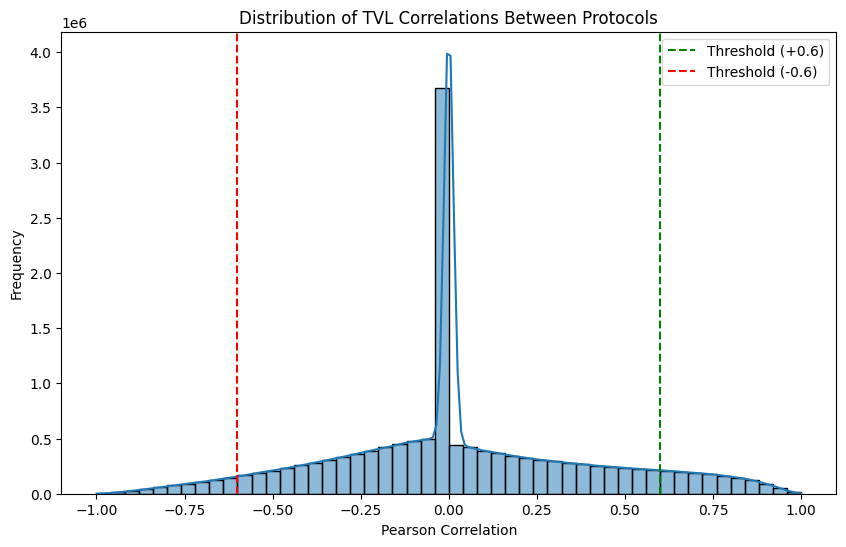

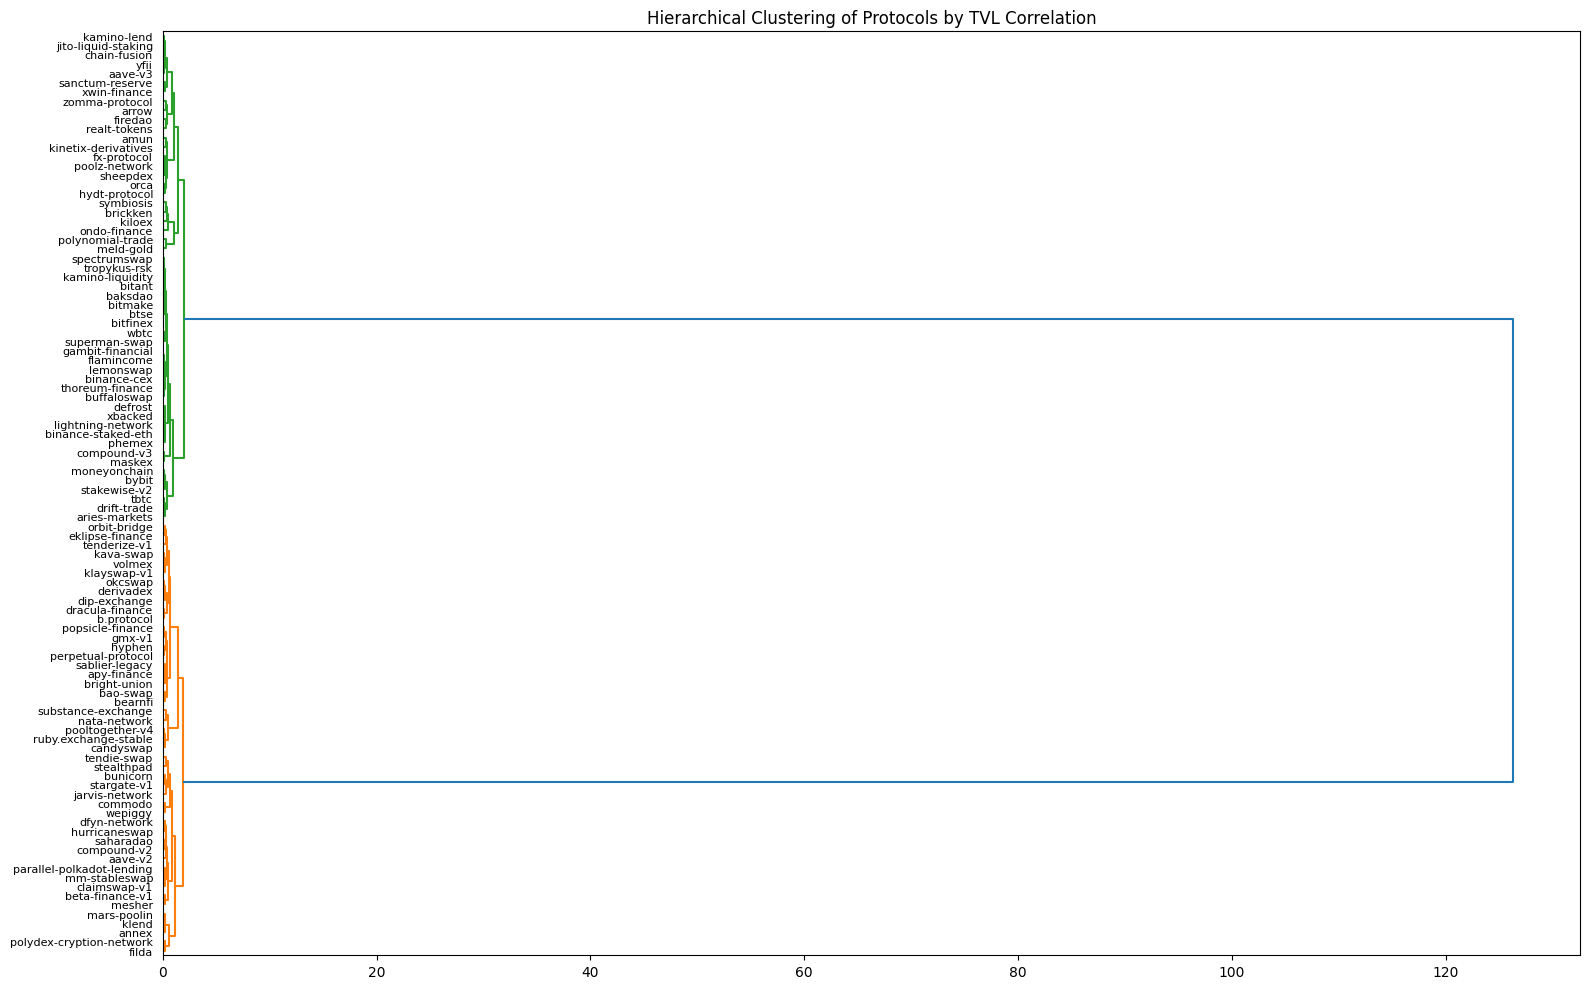

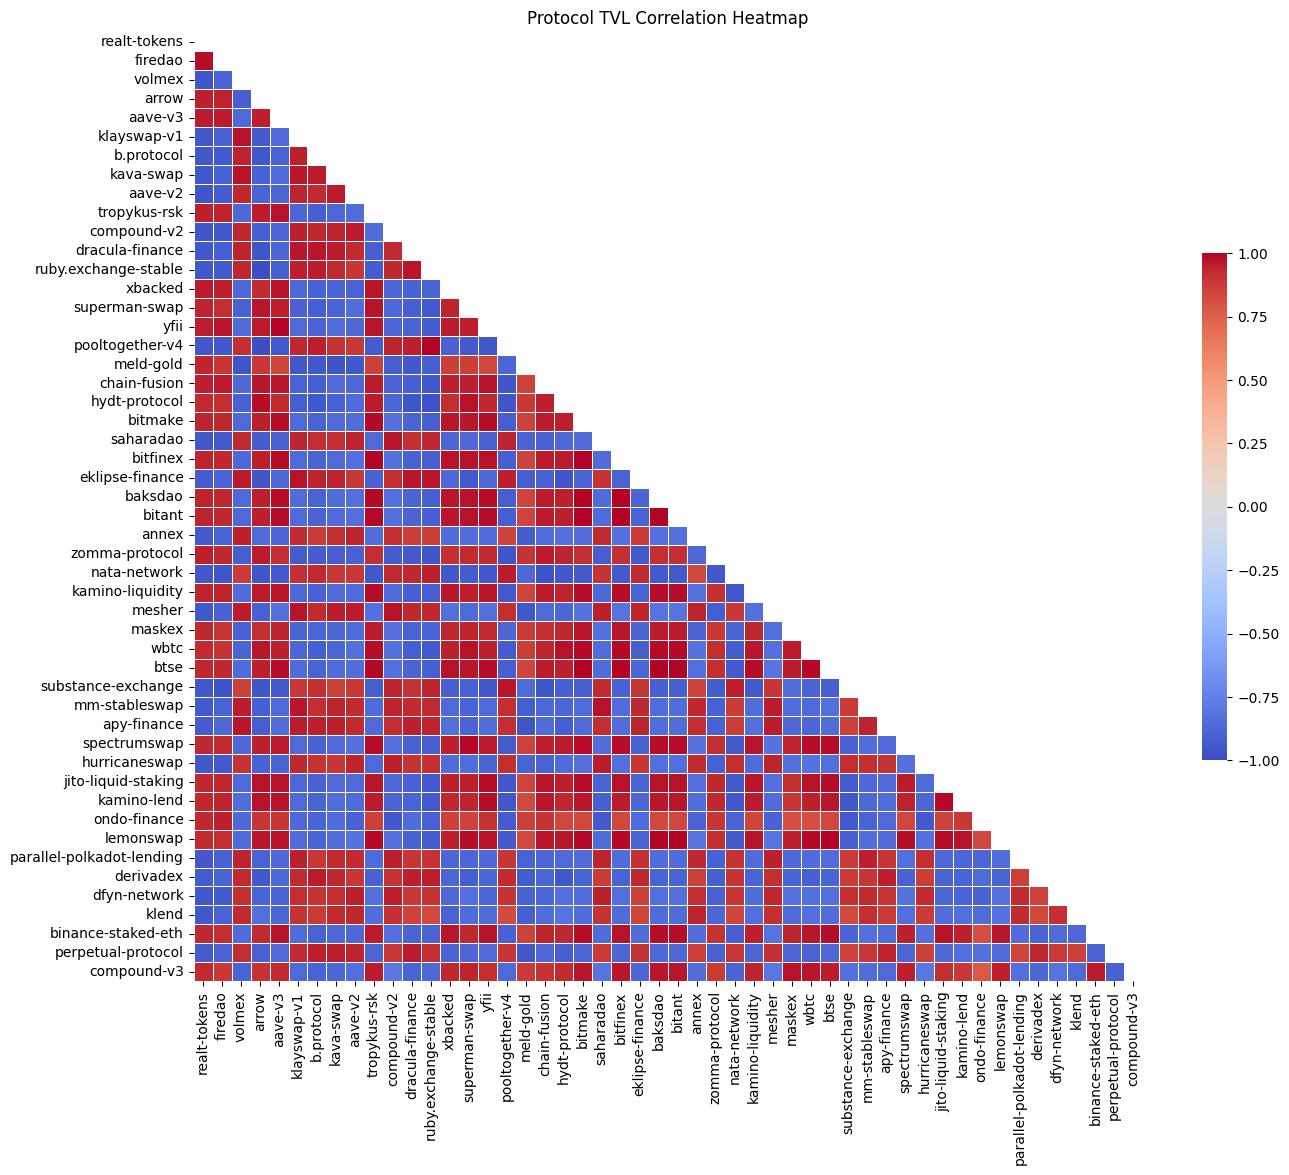

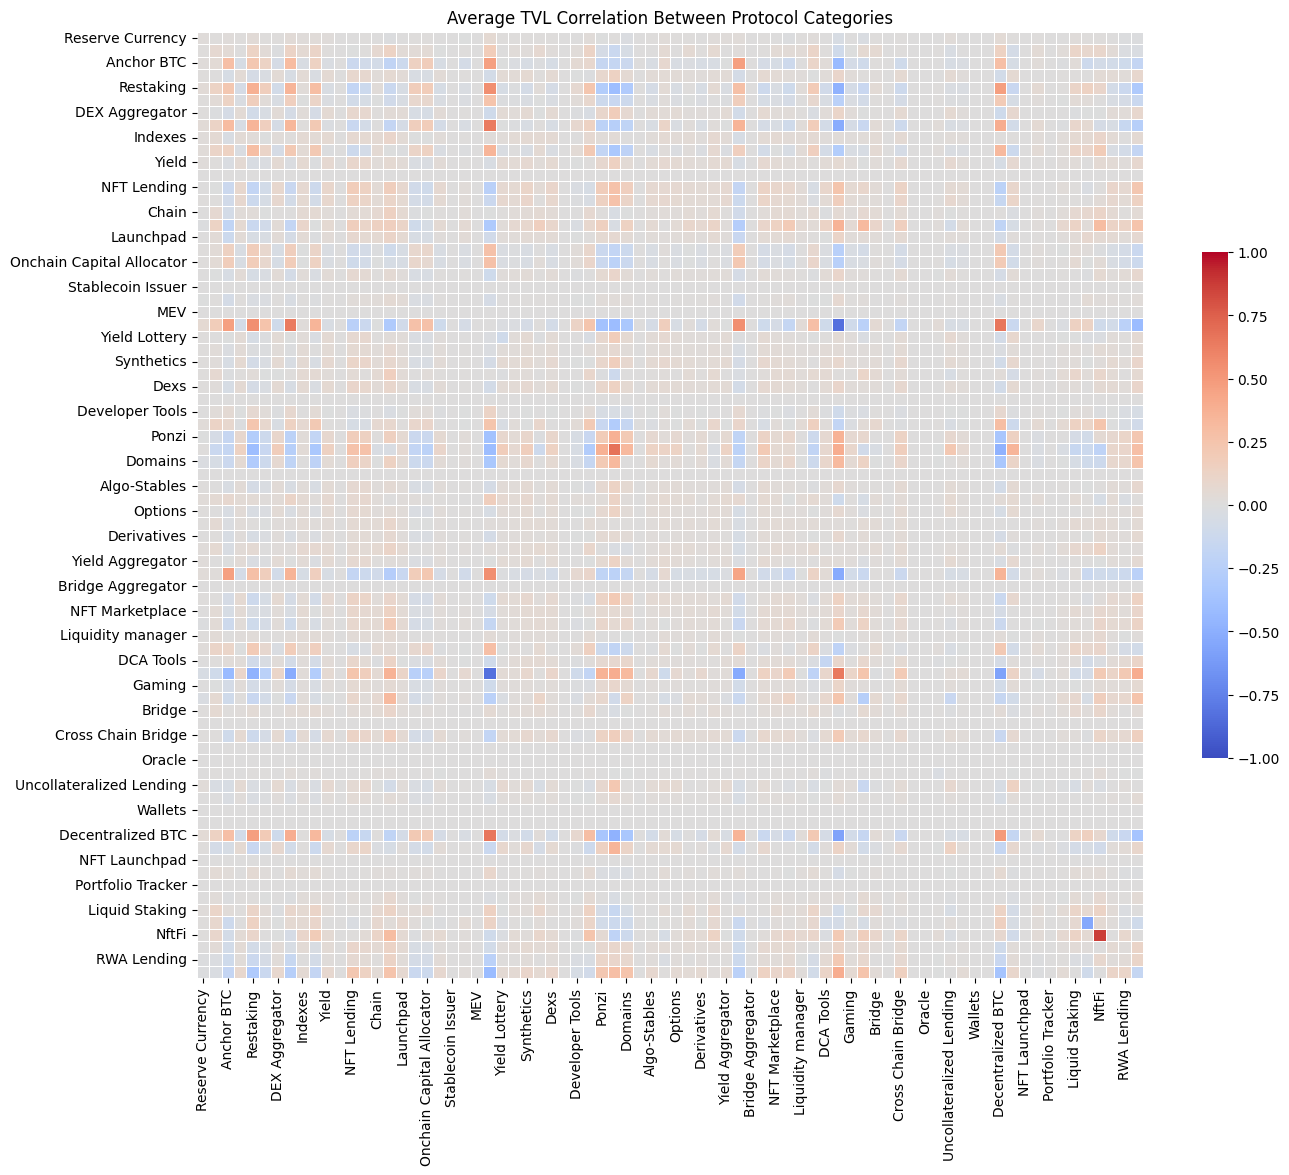

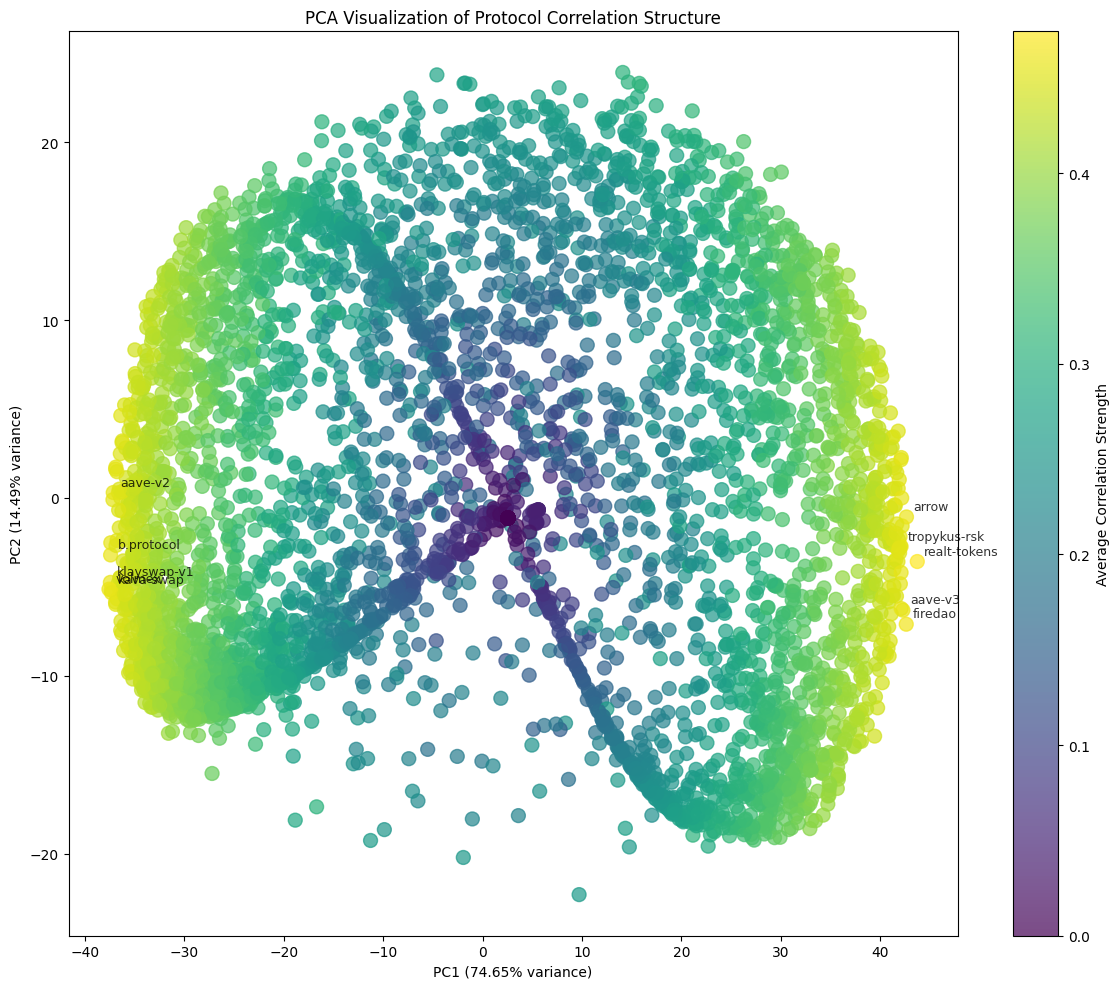

In [ ]:
def analyze_correlation_matrix_1(correlation_file, protocol_df=None, threshold=0.5, output_dir="./correlation_analysis/"):
    """
    Comprehensive analysis of DeFi protocol TVL correlations

    Parameters:
    - correlation_file: Path to CSV file containing correlation matrix
    - protocol_df: DataFrame with protocol metadata (optional)
    - threshold: Correlation threshold for considering strong relationships
    - output_dir: Directory to save output files and visualizations

    Returns:
    - Dictionary with analysis results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    print(f"Analyzing correlation matrix from {correlation_file}")

    # Load correlation matrix
    try:
        corr_matrix = pd.read_csv(correlation_file, index_col=0)
        print(f"Loaded correlation matrix with shape: {corr_matrix.shape}")
    except Exception as e:
        print(f"Error loading correlation matrix: {e}")
        return None

    # Fill NaN values with 0
    corr_matrix = corr_matrix.fillna(0)

    # Basic statistical analysis
    results = {}

    # 1. Basic correlation statistics
    all_corrs = corr_matrix.values[np.triu_indices_from(corr_matrix.values, k=1)]
    results['basic_stats'] = {
        'mean': np.mean(all_corrs),
        'median': np.median(all_corrs),
        'min': np.min(all_corrs),
        'max': np.max(all_corrs),
        'std': np.std(all_corrs)
    }

    # Distribution of correlation values
    results['distribution'] = {
        'positive_count': np.sum(all_corrs > 0),
        'negative_count': np.sum(all_corrs < 0),
        'strong_positive': np.sum(all_corrs > threshold),
        'strong_negative': np.sum(all_corrs < -threshold),
        'positive_pct': np.sum(all_corrs > 0) / len(all_corrs) * 100,
        'negative_pct': np.sum(all_corrs < 0) / len(all_corrs) * 100
    }

    # Print basic statistics
    print("\n--- Basic Correlation Statistics ---")
    print(f"Number of protocols: {corr_matrix.shape[0]}")
    print(f"Mean correlation: {results['basic_stats']['mean']:.4f}")
    print(f"Median correlation: {results['basic_stats']['median']:.4f}")
    print(f"Range: [{results['basic_stats']['min']:.4f}, {results['basic_stats']['max']:.4f}]")
    print(f"Standard deviation: {results['basic_stats']['std']:.4f}")

    print("\n--- Correlation Distribution ---")
    print(f"Positive correlations: {results['distribution']['positive_count']} ({results['distribution']['positive_pct']:.1f}%)")
    print(f"Negative correlations: {results['distribution']['negative_count']} ({results['distribution']['negative_pct']:.1f}%)")
    print(f"Strong positive (>{threshold}): {results['distribution']['strong_positive']}")
    print(f"Strong negative (<-{threshold}): {results['distribution']['strong_negative']}")

    # 2. Visualize correlation distribution
    plt.figure(figsize=(10, 6))
    sns.histplot(all_corrs, bins=50, kde=True)
    plt.title('Distribution of TVL Correlations Between Protocols')
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Frequency')
    plt.axvline(x=threshold, color='green', linestyle='--', label=f'Threshold (+{threshold})')
    plt.axvline(x=-threshold, color='red', linestyle='--', label=f'Threshold (-{threshold})')
    plt.legend()
    plt.savefig(f"{output_dir}correlation_distribution.png", dpi=300, bbox_inches='tight')

    # 3. Find most connected/correlated protocols
    avg_correlations = corr_matrix.abs().mean()
    top_connected = avg_correlations.sort_values(ascending=False).head(20)

    print("\n--- Top 20 Most Connected Protocols (Highest Average |Correlation|) ---")
    for i, (protocol, avg_corr) in enumerate(top_connected.items(), 1):
        print(f"{i}. {protocol}: {avg_corr:.4f}")

    results['top_connected'] = {p: c for p, c in top_connected.items()}

    # 7. Visualize correlation heatmap (for a manageable subset)
    try:
        if corr_matrix.shape[0] > 50:
            print("\nMatrix too large for heatmap visualization. Selecting top 50 protocols by average correlation.")
            top_protocols = avg_correlations.sort_values(ascending=False).head(50).index.tolist()
            heatmap_matrix = corr_matrix.loc[top_protocols, top_protocols]
        else:
            heatmap_matrix = corr_matrix

        plt.figure(figsize=(14, 12))
        mask = np.triu(np.ones_like(heatmap_matrix, dtype=bool))
        sns.heatmap(
            heatmap_matrix,
            mask=mask,
            cmap='coolwarm',
            vmin=-1,
            vmax=1,
            center=0,
            square=True,
            linewidths=.5,
            cbar_kws={"shrink": .5}
        )
        plt.title('Protocol TVL Correlation Heatmap')
        plt.tight_layout()
        plt.savefig(f"{output_dir}correlation_heatmap.png", dpi=300, bbox_inches='tight')

    except Exception as e:
        print(f"Error in heatmap generation: {e}")

    # 9. Dimensionality reduction to visualize correlation structure
    try:
        # Apply PCA to reduce dimensions
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(corr_matrix.values)

        # Create DataFrame with PCA results
        pca_df = pd.DataFrame({
            'protocol': corr_matrix.columns,
            'x': pca_result[:, 0],
            'y': pca_result[:, 1],
            'avg_correlation': avg_correlations.values
        })

        # Add category information if available
        if protocol_df is not None:
            pca_df['category'] = pca_df['protocol'].map(lambda p: slug_to_category.get(p, "Unknown"))

        # Create scatter plot
        plt.figure(figsize=(12, 10))
        scatter = plt.scatter(
            pca_df['x'],
            pca_df['y'],
            c=pca_df['avg_correlation'],
            cmap='viridis',
            alpha=0.7,
            s=100
        )

        # Add colorbar
        cbar = plt.colorbar(scatter)
        cbar.set_label('Average Correlation Strength')

        # Annotate some top protocols
        top_10_protocols = avg_correlations.sort_values(ascending=False).head(10).index
        for protocol in top_10_protocols:
            row = pca_df[pca_df['protocol'] == protocol]
            if not row.empty:
                plt.annotate(
                    protocol,
                    (row['x'].values[0], row['y'].values[0]),
                    fontsize=9,
                    alpha=0.8,
                    xytext=(5, 5),
                    textcoords='offset points'
                )

        plt.title('PCA Visualization of Protocol Correlation Structure')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
        plt.tight_layout()
        plt.savefig(f"{output_dir}pca_visualization.png", dpi=300, bbox_inches='tight')

        results['dimensionality_reduction'] = {
            'explained_variance': pca.explained_variance_ratio_.tolist(),
            'pca_data': pca_df.to_dict(orient='records')
        }

    except Exception as e:
        print(f"Error in PCA visualization: {e}")

    # 10. Save key results to CSV files
    try:
        # Save top correlated pairs
        corr_pairs = []
        for i, p1 in enumerate(corr_matrix.columns):
            for p2 in corr_matrix.columns[i+1:]:
                corr_val = corr_matrix.loc[p1, p2]
                if abs(corr_val) >= threshold:
                    corr_pairs.append({
                        'protocol1': p1,
                        'protocol2': p2,
                        'correlation': corr_val,
                        'abs_correlation': abs(corr_val),
                        'type': 'positive' if corr_val >= 0 else 'negative'
                    })

        corr_pairs_df = pd.DataFrame(corr_pairs)
        if not corr_pairs_df.empty:
            corr_pairs_df = corr_pairs_df.sort_values('abs_correlation', ascending=False)
            corr_pairs_df.to_csv(f"{output_dir}strong_correlations.csv", index=False)
            print(f"\nSaved {len(corr_pairs_df)} strong correlation pairs to {output_dir}strong_correlations.csv")

    except Exception as e:
        print(f"Error saving results: {e}")

    print("\nAnalysis complete. Results and visualizations saved to:", output_dir)
    return results

correlation_file = "defi_data/result_protocol_tvl_correlations.csv"
# Run analysis
results = analyze_correlation_matrix_1(
    correlation_file=correlation_file,
    protocol_df=clean_protocols,
    threshold=0.6,  # Correlation threshold
    output_dir="./correlation_analysis/"
)

In [ ]:
cat_matrix=None
category_stats=None

Analyzing correlation matrix from protocol_tvl_correlations.csv
Loaded correlation matrix with shape: (5457, 5457)
Total number of unique categories found: 76
Selected 40 important categories for visualization

Top protocol categories by importance:
1. Dexs: 1604 protocols, avg |corr| = 0.2844, importance = 2.10
2. Lending: 504 protocols, avg |corr| = 0.2880, importance = 1.79
3. Derivatives: 309 protocols, avg |corr| = 0.2938, importance = 1.69
4. Liquid Staking: 218 protocols, avg |corr| = 0.3094, importance = 1.67
5. Yield: 550 protocols, avg |corr| = 0.2637, importance = 1.66
6. CDP: 181 protocols, avg |corr| = 0.2953, importance = 1.54
7. Bridge: 111 protocols, avg |corr| = 0.3009, importance = 1.42
8. Yield Aggregator: 174 protocols, avg |corr| = 0.2704, importance = 1.40
9. CEX: 63 protocols, avg |corr| = 0.3234, importance = 1.35
10. RWA: 84 protocols, avg |corr| = 0.3026, importance = 1.34
11. Indexes: 65 protocols, avg |corr| = 0.3070, importance = 1.29
12. Liquidity manager:

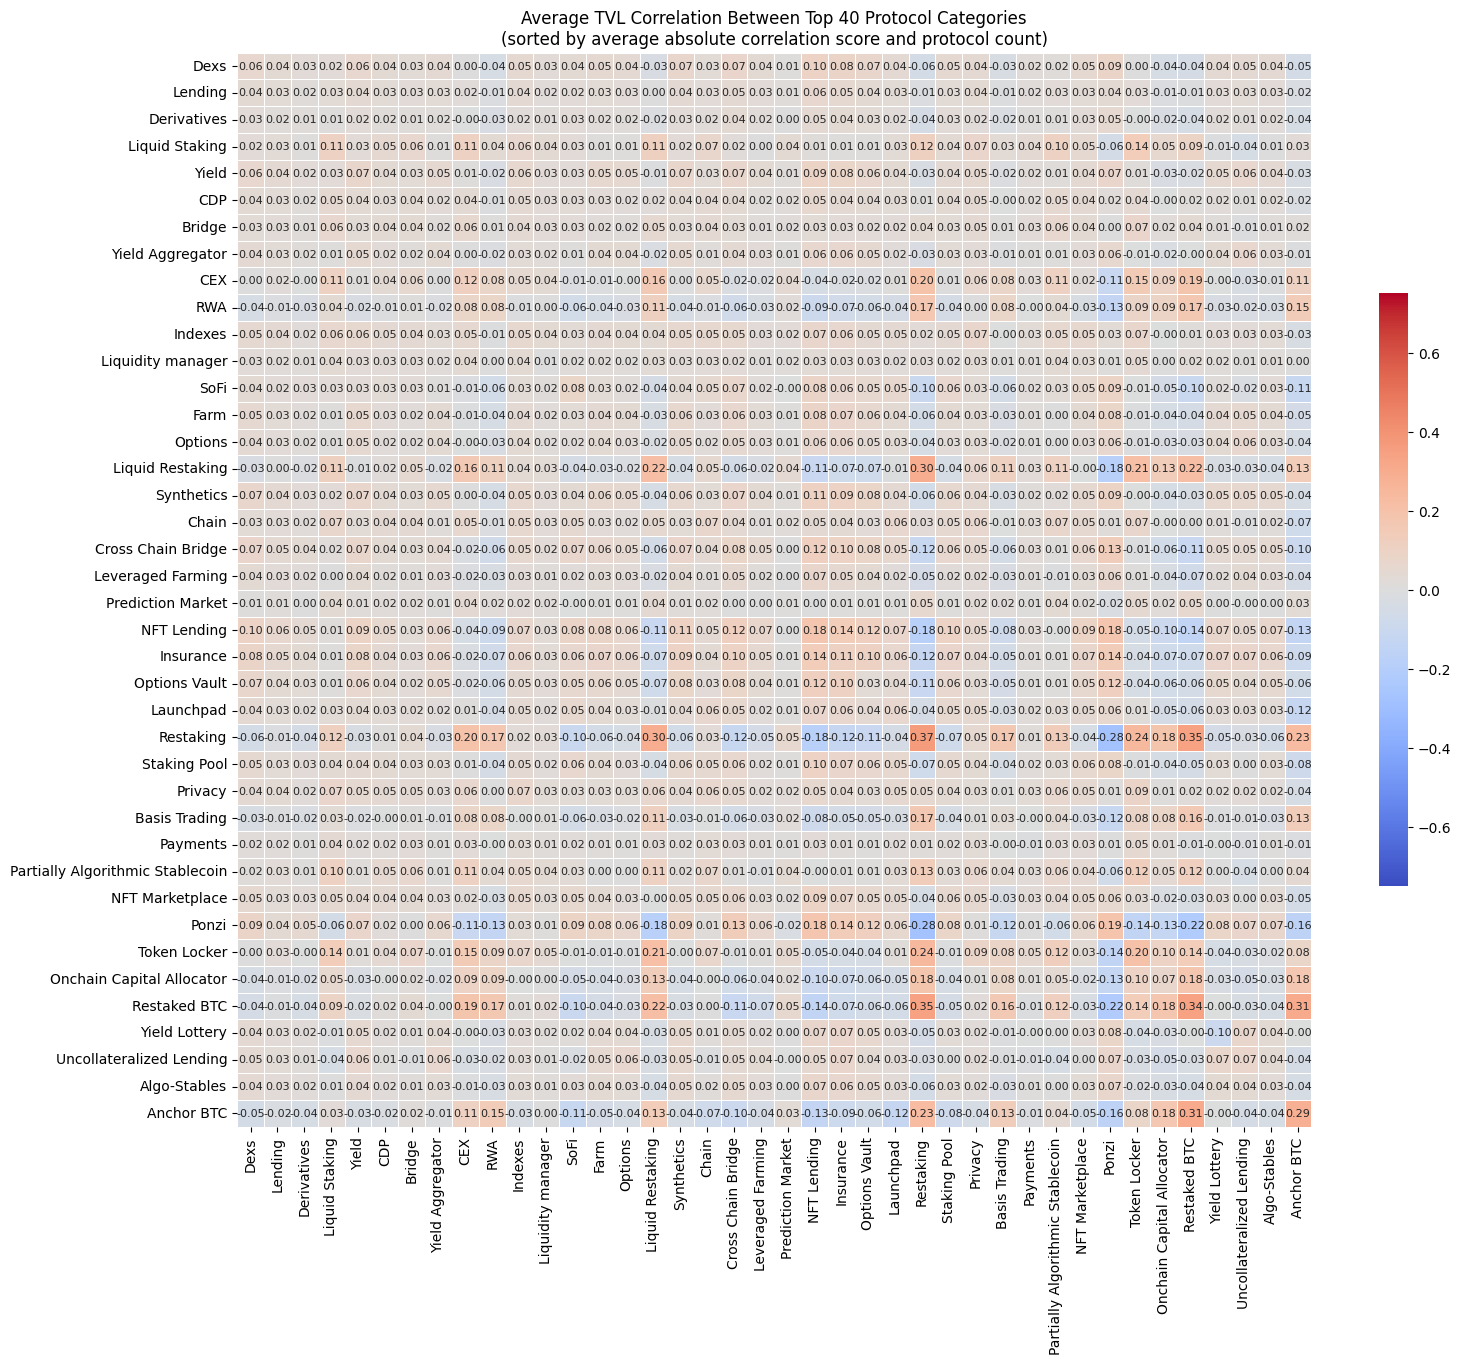

In [ ]:
def analyze_correlation_matrix_2(correlation_file, cat_matrix=None, category_stats=None, protocol_df=None, output_dir="./correlation_analysis/"):
    """
    Comprehensive analysis of DeFi protocol TVL correlations

    Parameters:
    - correlation_file: Path to CSV file containing correlation matrix
    - protocol_df: DataFrame with protocol metadata (optional)
    - output_dir: Directory to save output files and visualizations

    Returns:
    - Dictionary with analysis results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    print(f"Analyzing correlation matrix from {correlation_file}")

    # Load correlation matrix
    try:
        corr_matrix = pd.read_csv(correlation_file, index_col=0)
        print(f"Loaded correlation matrix with shape: {corr_matrix.shape}")
    except Exception as e:
        print(f"Error loading correlation matrix: {e}")
        return None

    # Fill NaN values with 0
    corr_matrix = corr_matrix.fillna(0)

    # Basic statistical analysis
    results = {}

    # 8. Category-based analysis with filtering for most important categories
    if protocol_df is not None:
        try:
            # Create mapping from protocol slug to category
            slug_to_category = {}
            for _, row in protocol_df.iterrows():
                if 'slug' in row and 'category' in row:
                    if pd.notna(row['slug']) and pd.notna(row['category']):
                        slug_to_category[row['slug']] = row['category']

            # Calculate average correlation between categories
            categories = list(set(slug_to_category.values()))
            print(f"Total number of unique categories found: {len(categories)}")


            # Track protocols per category and correlation count
            if cat_matrix is None and category_stats is None:
                cat_matrix = pd.DataFrame(index=categories, columns=categories, dtype=float)
                category_stats = {}
                for cat1 in categories:
                    cat1_protocols = [p for p in corr_matrix.columns if p in slug_to_category and slug_to_category[p] == cat1]
                    category_stats[cat1] = {
                        'protocol_count': len(cat1_protocols),
                        'total_abs_corr': 0,
                        'valid_corr_count': 0
                    }

                    for cat2 in categories:
                        cat2_protocols = [p for p in corr_matrix.columns if p in slug_to_category and slug_to_category[p] == cat2]

                        if cat1_protocols and cat2_protocols:
                            # Get all correlations between protocols in these categories
                            if cat1 == cat2:
                                # For same category, only get unique pairs
                                corrs = []
                                for i, p1 in enumerate(cat1_protocols):
                                    for p2 in cat1_protocols[i+1:]:
                                        corr_val = corr_matrix.loc[p1, p2]
                                        if not np.isnan(corr_val):  # Exclude NaN correlations
                                            corrs.append(corr_val)
                                            category_stats[cat1]['total_abs_corr'] += abs(corr_val)
                                            category_stats[cat1]['valid_corr_count'] += 1
                                avg_corr = np.mean(corrs) if corrs else np.nan
                            else:
                                # For different categories, get all cross-correlations
                                corrs = []
                                for p1 in cat1_protocols:
                                    for p2 in cat2_protocols:
                                        corr_val = corr_matrix.loc[p1, p2]
                                        if not np.isnan(corr_val):  # Exclude NaN correlations
                                            corrs.append(corr_val)
                                            # For cross-category, add to both categories
                                            category_stats[cat1]['total_abs_corr'] += abs(corr_val)
                                            category_stats[cat1]['valid_corr_count'] += 1
                                avg_corr = np.mean(corrs) if corrs else np.nan
                        else:
                            avg_corr = np.nan

                        cat_matrix.loc[cat1, cat2] = avg_corr

            # Calculate importance score for each category
            for cat, stats in category_stats.items():
                if stats['valid_corr_count'] > 0:
                    # Importance = avg correlation strength × protocol count
                    stats['avg_abs_corr'] = stats['total_abs_corr'] / stats['valid_corr_count']
                    stats['importance_score'] = stats['avg_abs_corr'] * math.log(1 + stats['protocol_count']) ####################
                else:
                    stats['avg_abs_corr'] = 0
                    stats['importance_score'] = 0

            # Sort categories by importance score
            sorted_categories = sorted(
                category_stats.items(),
                key=lambda x: x[1]['importance_score'],
                reverse=True
            )

            # Select top 40 categories with non-zero correlation
            top_categories = [cat for cat, stats in sorted_categories[:40]
                            if stats['valid_corr_count'] > 0 and stats['avg_abs_corr'] > 0.01]

            print(f"Selected {len(top_categories)} important categories for visualization")

            # Create filtered correlation matrix
            filtered_matrix = cat_matrix.loc[top_categories, top_categories]

            # Fill remaining NaN values with zeros
            filtered_matrix = filtered_matrix.fillna(0)

            # Print the categories and their stats
            print("\nTop protocol categories by importance:")
            for i, cat in enumerate(top_categories[:20], 1):
                stats = category_stats[cat]
                print(f"{i}. {cat}: {stats['protocol_count']} protocols, " +
                    f"avg |corr| = {stats['avg_abs_corr']:.4f}, " +
                    f"importance = {stats['importance_score']:.2f}")

            # Visualize filtered category correlation matrix
            plt.figure(figsize=(16, 14))
            mask = np.zeros_like(filtered_matrix, dtype=bool)

            # Set a minimum correlation threshold for display clarity (optional)
            # threshold = 0.05
            # filtered_matrix_display = filtered_matrix.copy()
            # filtered_matrix_display[abs(filtered_matrix_display) < threshold] = 0

            # Create heatmap with annotations for strong correlations
            heatmap = sns.heatmap(
                filtered_matrix,
                cmap='coolwarm',
                vmin=-0.75,
                vmax=0.75,
                center=0,
                square=True,
                linewidths=.5,
                annot=True,  # Show all values
                fmt=".2f",
                annot_kws={"size": 8},
                cbar_kws={"shrink": .5}
            )

            # Rotate y-axis labels for better readability
            plt.yticks(rotation=0)
            plt.xticks(rotation=90)

            plt.title('Average TVL Correlation Between Top 40 Protocol Categories\n(sorted by average absolute correlation score and protocol count)')
            plt.tight_layout()
            plt.savefig(f"{output_dir}top_category_correlation_heatmap.png", dpi=300, bbox_inches='tight')

        except Exception as e:
            print(f"Error in category-based analysis: {e}")


    print("\nAnalysis complete. Results and visualizations saved to:", output_dir)
    return results, cat_matrix, category_stats

correlation_file = "defi_data/result_protocol_tvl_correlations.csv"
# Run analysis
results, cat_matrix, category_stats = analyze_correlation_matrix_2(
    correlation_file=correlation_file,
    cat_matrix=cat_matrix,
    category_stats=category_stats,
    protocol_df=clean_protocols,
    output_dir="./correlation_analysis/"
)

In [ ]:
def create_graph(correlation_file, protocol_df=None, threshold=0.5):
    print(f"Analyzing correlation matrix from {correlation_file}")

    # Load correlation matrix
    try:
        corr_matrix = pd.read_csv(correlation_file, index_col=0)
        print(f"Loaded correlation matrix with shape: {corr_matrix.shape}")
    except Exception as e:
        print(f"Error loading correlation matrix: {e}")
        return None

    # Fill NaN values with 0
    corr_matrix = corr_matrix.fillna(0)

    # 4. Create a network from the correlation matrix
    G = nx.Graph()

    # Create a lookup dictionary for protocol attributes if protocol_df is provided
    protocol_attributes = {}
    if protocol_df is not None:
        print("Adding protocol metadata (TVL, category) to nodes...")
        for _, row in protocol_df.iterrows():
            if 'slug' in row and pd.notna(row['slug']):
                slug = str(row['slug'])

                # Extract TVL
                tvl = 0
                if 'tvl' in row and pd.notna(row['tvl']):
                    try:
                        if isinstance(row['tvl'], str):
                            tvl = float(row['tvl'].replace(',', ''))
                        else:
                            tvl = float(row['tvl'])
                    except Exception as e:
                        print(f"there was an exception: {e}")

                # Extract category
                category = None
                if 'category' in row and pd.notna(row['category']):
                    category = row['category']

                # Extract name
                name = slug
                if 'name' in row and pd.notna(row['name']):
                    name = row['name']

                # Extract chain/blockchain information
                chains = None
                # Check various possible column names for chain info
                for chain_col in ['chains', 'chain', 'blockchain', 'network']:
                    if chain_col in row:
                        chains = row[chain_col]
                        break

                # Store attributes
                protocol_attributes[slug] = {
                    'tvl': tvl,
                    'category': category,
                    'name': name,
                    'chains' : chains,
                }

    # Add nodes with attributes
    for protocol in corr_matrix.columns:
        # Default attributes
        node_attrs = {'name': protocol}

        # Add metadata from protocol_df if available
        if protocol in protocol_attributes:
            for key, value in protocol_attributes[protocol].items():
                node_attrs[key] = value

        G.add_node(protocol, **node_attrs)

    # Add edges for strong correlations (above threshold)
    strong_pairs = 0
    for i, protocol1 in enumerate(corr_matrix.columns):
        for protocol2 in corr_matrix.columns[i+1:]:
            corr = corr_matrix.loc[protocol1, protocol2]
            if abs(corr) >= threshold:
                G.add_edge(
                    protocol1,
                    protocol2,
                    weight=abs(corr),
                    corr_type="positive" if corr >= 0 else "negative"
                )
                strong_pairs += 1

    # Find protocols with no connections
    isolated_nodes = [n for n in G.nodes() if G.degree(n) == 0]
    print(f"\nFound {len(isolated_nodes)} protocols with no connections above threshold")

    # For each isolated protocol, add edges to its top 10 correlations
    additional_edges = 0
    for protocol in isolated_nodes:
        # Get correlations for this protocol
        correlations = []
        for other_protocol in corr_matrix.columns:
            if protocol != other_protocol:
                corr = corr_matrix.loc[protocol, other_protocol]
                if not pd.isna(corr):  # Skip NaN values
                    correlations.append((other_protocol, corr, abs(corr)))

        # Sort by absolute correlation strength (descending)
        correlations.sort(key=lambda x: x[2], reverse=True)

        # Add edges to top 10 protocols with strongest correlations
        top_protocols = correlations[:10]
        for other_protocol, corr, abs_corr in top_protocols:
            G.add_edge(
                protocol,
                other_protocol,
                weight=abs_corr,
                corr_type="positive" if corr >= 0 else "negative",
                is_forced=True  # Flag to indicate this edge was added for connectivity
            )
            additional_edges += 1

    print(f"Added {additional_edges} additional edges to connect isolated protocols")
    print(f"Final network: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # Print node attribute statistics
    tvl_nodes = sum(1 for n in G.nodes() if G.nodes[n].get('tvl', 0) > 0)
    category_nodes = sum(1 for n in G.nodes() if G.nodes[n].get('category') is not None)
    print(f"Nodes with TVL data: {tvl_nodes}/{G.number_of_nodes()}")
    print(f"Nodes with category data: {category_nodes}/{G.number_of_nodes()}")

    return G

correlation_file = "defi_data/result_protocol_tvl_correlations.csv"
# Run analysis
G = create_graph(
    correlation_file=correlation_file,
    protocol_df=clean_protocols,
    threshold=0.6,  # Correlation threshold
)

Analyzing correlation matrix from protocol_tvl_correlations.csv
Loaded correlation matrix with shape: (5457, 5457)
Adding protocol metadata (TVL, category) to nodes...

Found 671 protocols with no connections above threshold
Added 6710 additional edges to connect isolated protocols
Final network: 5457 nodes and 2052447 edges
Nodes with TVL data: 4607/5457
Nodes with category data: 5457/5457


In [19]:
{
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'connected_components': nx.number_connected_components(G)
}

{'nodes': 5457,
 'edges': 2052447,
 'density': 0.13787122407819707,
 'connected_components': 5}

In [ ]:
# Save the graph G to a file
with open('defi_data/defi_graph.pkl', 'wb') as f:
    pickle.dump(G, f)

print("Graph saved successfully.")

In [ ]:
def analyze_graph(G, output_dir="./graph_analysis/"):
    # Network statistics
    results['network_stats'] = {
        'nodes': G.number_of_nodes(),
        'edges': G.number_of_edges(),
        'density': nx.density(G),
        'connected_components': nx.number_connected_components(G)
    }

    print("\n--- Correlation Network Statistics ---")
    print(f"Network size: {results['network_stats']['nodes']} nodes, {results['network_stats']['edges']} edges")
    print(f"Network density: {results['network_stats']['density']:.5f}")
    print(f"Connected components: {results['network_stats']['connected_components']}")

    # 5. Identify clusters using community detection and visualize communities
    if G.number_of_nodes() > 0 and G.number_of_edges() > 0:
        try:
            import matplotlib.cm as cm
            from matplotlib.colors import rgb2hex
            from networkx.algorithms.centrality import betweenness_centrality, eigenvector_centrality_numpy, degree_centrality

            print("\nRunning community detection and protocol importance analysis...")

            # Use Louvain method for community detection
            communities = community_louvain.best_partition(G)
            nx.set_node_attributes(G, communities, 'community')

            # Count protocols in each community
            community_sizes = {}
            community_members = {}
            for node, comm in communities.items():
                if comm not in community_sizes:
                    community_sizes[comm] = 0
                    community_members[comm] = []
                community_sizes[comm] += 1
                community_members[comm].append(node)

            # Sort communities by size
            sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

            print(f"\n--- Found {len(sorted_communities)} Protocol Communities Based on Correlation ---")
            for i, (comm_id, size) in enumerate(sorted_communities[:10]):
                print(f"Community {i+1} (ID:{comm_id}): {size} protocols")

            # Calculate network centrality metrics for protocol importance
            print("\nCalculating protocol centrality metrics...")

            # Calculate centrality measures (try each but handle errors gracefully)
            centrality_measures = {}

            try:
                print("- Calculating degree centrality...")
                centrality_measures['degree'] = degree_centrality(G)
            except Exception as e:
                print(f"  Error calculating degree centrality: {str(e)}")
                centrality_measures['degree'] = {n: 0 for n in G.nodes()}

            try:
                # Use approximation for large networks
                if G.number_of_nodes() > 5000:
                    print("- Large network detected, using approximate betweenness centrality...")
                    # Use k=1000 for sampling, or adjust based on network size
                    k = min(1000, G.number_of_nodes())
                    centrality_measures['betweenness'] = betweenness_centrality(G, k=k, seed=42)
                else:
                    print("- Calculating betweenness centrality...")
                    centrality_measures['betweenness'] = betweenness_centrality(G)
            except Exception as e:
                print(f"  Error calculating betweenness centrality: {str(e)}")
                centrality_measures['betweenness'] = {n: 0 for n in G.nodes()}

            try:
                print("- Calculating eigenvector centrality...")
                if G.number_of_nodes() < 5000:  # Eigenvector calculation is memory intensive
                    centrality_measures['eigenvector'] = eigenvector_centrality_numpy(G, max_iter=100)
                else:
                    print("  Network too large for eigenvector centrality, skipping...")
                    centrality_measures['eigenvector'] = {n: 0 for n in G.nodes()}
            except Exception as e:
                print(f"  Error calculating eigenvector centrality: {str(e)}")
                centrality_measures['eigenvector'] = {n: 0 for n in G.nodes()}

            # Add centrality measures to node attributes
            for measure_name, measure_dict in centrality_measures.items():
                nx.set_node_attributes(G, measure_dict, measure_name)

            # Calculate composite importance score for each node
            importance_scores = {}
            for node in G.nodes():
                # Weighted combination of centrality measures
                importance_scores[node] = (
                    0.4 * centrality_measures['degree'].get(node, 0) +
                    0.4 * centrality_measures['betweenness'].get(node, 0) +
                    0.2 * centrality_measures['eigenvector'].get(node, 0)
                )

            nx.set_node_attributes(G, importance_scores, 'importance')

            # Identify top protocols in each community
            community_top_protocols = {}
            community_descriptions = {}

            for comm_id in community_members:
                # Get all nodes in this community
                comm_nodes = community_members[comm_id]

                # Sort nodes by importance
                comm_nodes_sorted = sorted(comm_nodes,
                                        key=lambda n: importance_scores.get(n, 0),
                                        reverse=True)

                # Get top 20 protocols
                top_protocols = comm_nodes_sorted[:20]
                community_top_protocols[comm_id] = top_protocols

                # Create descriptive text for each community
                node_names = []
                for node in top_protocols:
                    name = G.nodes[node].get('name', node)
                    importance = importance_scores.get(node, 0)
                    node_names.append((name, importance))

                community_descriptions[comm_id] = node_names

            # Print top protocols in each community
            print("\n--- Top Protocols in Major Communities ---")
            for i, (comm_id, size) in enumerate(sorted_communities[:5]):  # Show top 5 communities
                print(f"\nCommunity {i+1} (Size: {size} protocols)")
                for j, protocol in enumerate(community_top_protocols[comm_id][:20]):
                    name = G.nodes[protocol].get('name', protocol)
                    importance = importance_scores.get(protocol, 0)
                    print(f"  {j+1}. {name} (Importance: {importance:.4f})")

            # Store community results
            results['communities'] = {
                'count': len(set(communities.values())),
                'sizes': community_sizes,
                'modularity': community_louvain.modularity(communities, G),
                'top_protocols': {k: v for k, v in community_top_protocols.items()}
            }


            # 3. Create community protocol lists as text files
            print("- Saving community membership lists...")
            os.makedirs(f"{output_dir}communities/", exist_ok=True)

            for i, (comm_id, size) in enumerate(sorted_communities[:10]):
                comm_nodes = community_members[comm_id]

                # Sort by importance
                sorted_nodes = sorted(comm_nodes,
                                    key=lambda n: importance_scores.get(n, 0),
                                    reverse=True)

                # Create file with protocol details
                with open(f"{output_dir}communities/community_{i+1}_protocols.csv", "w") as f:
                    f.write("Rank,Protocol,Name,Importance,Degree,Betweenness,Eigenvector\n")

                    for j, node in enumerate(sorted_nodes):
                        name = G.nodes[node].get('name', node)
                        importance = importance_scores.get(node, 0)
                        degree = centrality_measures['degree'].get(node, 0)
                        betweenness = centrality_measures['betweenness'].get(node, 0)
                        eigenvector = centrality_measures['eigenvector'].get(node, 0)

                        f.write(f"{j+1},{node},{name},{importance:.6f},{degree:.6f},{betweenness:.6f},{eigenvector:.6f}\n")

        except Exception as e:
            print(f"Error in community detection: {e}")
            import traceback
            traceback.print_exc()

        # 6. Additional Network Analysis Methods
        print("\n--- Additional Network Analyses ---")

        try:
            # Calculate network-level metrics
            results['network_metrics'] = {
                'density': nx.density(G),
                'transitivity': nx.transitivity(G),
                'avg_clustering': nx.average_clustering(G),
            }

            print(f"Network density: {results['network_metrics']['density']:.6f}")
            print(f"Network transitivity: {results['network_metrics']['transitivity']:.6f}")
            print(f"Average clustering coefficient: {results['network_metrics']['avg_clustering']:.6f}")

            # Identify structural holes and bridges (edges whose removal would disconnect the network)
            try:
                print("\nIdentifying critical bridges in the network...")
                bridges = list(nx.bridges(G.to_undirected()))[:20]  # Get top 20 bridges

                if bridges:
                    print("Top critical bridges (edges whose removal disconnects parts of the network):")
                    for i, (u, v) in enumerate(bridges[:10]):
                        u_name = G.nodes[u].get('name', u)
                        v_name = G.nodes[v].get('name', v)
                        print(f"  {i+1}. {u_name} -- {v_name}")

                    results['bridges'] = [(u, v) for u, v in bridges]
                else:
                    print("No critical bridges found")
            except Exception as e:
                print(f"Error identifying bridges: {e}")

            # Identify potential contagion pathways using shortest paths between high-TVL protocols
            try:
                print("\nAnalyzing potential contagion pathways...")

                # Get top protocols by TVL
                top_tvl_protocols = sorted(
                    [(n, G.nodes[n].get('tvl', 0)) for n in G.nodes() if G.nodes[n].get('tvl', 0) > 0],
                    key=lambda x: x[1], reverse=True
                )[:20]

                if len(top_tvl_protocols) >= 2:
                    # Calculate shortest paths between some top protocols
                    contagion_paths = {}

                    for i, (source, _) in enumerate(top_tvl_protocols[:5]):
                        source_name = G.nodes[source].get('name', source)

                        for target, _ in top_tvl_protocols[i+1:8]:  # Limit number of paths
                            target_name = G.nodes[target].get('name', target)

                            try:
                                path = nx.shortest_path(G, source=source, target=target, weight='weight')
                                path_names = [G.nodes[n].get('name', n) for n in path]
                                contagion_paths[f"{source_name} to {target_name}"] = path_names
                            except:
                                pass

                    if contagion_paths:
                        print("Sample contagion pathways between major protocols:")
                        for path_name, nodes in list(contagion_paths.items())[:5]:
                            print(f"  {path_name}: {' -> '.join(nodes[:5])}..." +
                                (f" (+{len(nodes)-5} more)" if len(nodes) > 5 else ""))

                        results['contagion_paths'] = contagion_paths

            except Exception as e:
                print(f"Error analyzing contagion pathways: {e}")

            # Rich Club Analysis - identifies whether high-degree nodes are more connected to each other
            try:
                print("\nPerforming rich club analysis...")

                # Implement a simplified rich club analysis
                # Group nodes by degree percentile and measure internal connectivity
                degrees = dict(G.degree())
                percentiles = np.percentile(list(degrees.values()), [50, 75, 90, 95, 99])

                rich_club_data = defaultdict(dict)

                for p_idx, p in enumerate([50, 75, 90, 95, 99]):
                    # Get nodes above this percentile
                    threshold = percentiles[p_idx]
                    high_degree_nodes = [n for n, d in degrees.items() if d >= threshold]

                    # Skip if too few nodes
                    if len(high_degree_nodes) < 2:
                        continue

                    # Create subgraph of these nodes
                    high_degree_subgraph = G.subgraph(high_degree_nodes)

                    # Calculate density
                    density = nx.density(high_degree_subgraph)

                    rich_club_data[p] = {
                        'threshold': threshold,
                        'num_nodes': len(high_degree_nodes),
                        'density': density,
                        'avg_degree': sum(dict(high_degree_subgraph.degree()).values()) / len(high_degree_nodes)
                        if len(high_degree_nodes) > 0 else 0
                    }

                # Print rich club results
                print("Rich club analysis results:")
                print("Percentile | Min Degree | # Nodes | Density | Avg Degree")
                print("-" * 60)
                for p in sorted(rich_club_data.keys()):
                    data = rich_club_data[p]
                    print(f"{p:9}% | {data['threshold']:10.1f} | {data['num_nodes']:7} | " +
                        f"{data['density']:7.4f} | {data['avg_degree']:10.2f}")

                results['rich_club_analysis'] = rich_club_data

            except Exception as e:
                print(f"Error in rich club analysis: {e}")

            # Core-Periphery Analysis
            try:
                print("\nPerforming core-periphery analysis...")

                # We'll implement a simplified k-core decomposition
                core_numbers = nx.core_number(G)
                max_core = max(core_numbers.values())

                core_distributions = {}
                for k in range(1, min(max_core + 1, 11)):  # Up to max_core or 10, whichever is smaller
                    core_k_nodes = [n for n, c in core_numbers.items() if c >= k]
                    core_distributions[k] = len(core_k_nodes)

                print(f"Maximum core number: {max_core}")
                print("K-core decomposition:")
                for k, count in core_distributions.items():
                    print(f"  {k}-core: {count} nodes")

                results['core_periphery'] = {
                    'max_core': max_core,
                    'core_distribution': core_distributions
                }

            except Exception as e:
                print(f"Error in core-periphery analysis: {e}")

        except Exception as e:
            print(f"Error in additional network analyses: {e}")

analyze_graph(
    G,
    output_dir="./graph_analysis/"
)


--- Correlation Network Statistics ---
Network size: 5457 nodes, 2052447 edges
Network density: 0.13787
Connected components: 5

Running community detection and protocol importance analysis...

--- Found 631 Protocol Communities Based on Correlation ---
Community 1 (ID:1): 1560 protocols
Community 2 (ID:27): 1350 protocols
Community 3 (ID:2): 1292 protocols
Community 4 (ID:3): 600 protocols
Community 5 (ID:14): 13 protocols
Community 6 (ID:26): 9 protocols
Community 7 (ID:10): 3 protocols
Community 8 (ID:23): 3 protocols
Community 9 (ID:12): 2 protocols
Community 10 (ID:24): 2 protocols

Calculating protocol centrality metrics...
- Calculating degree centrality...
- Large network detected, using approximate betweenness centrality...
- Calculating eigenvector centrality...
  Network too large for eigenvector centrality, skipping...

--- Top Protocols in Major Communities ---

Community 1 (Size: 1560 protocols)
  1. wbtc (Importance: 0.2062)
  2. robinhood (Importance: 0.1962)
  3. lido

In [24]:
# 1. Run community detection if not already done
print("Running community detection...")
communities = community_louvain.best_partition(G)
nx.set_node_attributes(G, communities, 'community')

# 2. Group protocols by community
community_members = defaultdict(list)
for node, comm_id in communities.items():
    community_members[comm_id].append(node)

# 3. Count protocols in each community and sort by size
community_sizes = {comm_id: len(members) for comm_id, members in community_members.items()}
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)

print(f"Found {len(community_members)} communities")
print("\nTop 10 communities by size:")
for i, (comm_id, size) in enumerate(sorted_communities[:10]):
    print(f"Community {i+1} (ID:{comm_id}): {size} protocols")

# 4. Find top TVL protocols in each community
top_tvl_by_community = {}

for comm_id, members in community_members.items():
    # Get TVL for each protocol in this community
    protocol_tvl = []

    for protocol in members:
        # Extract TVL from node attributes
        tvl = G.nodes[protocol].get('tvl', 0)
        category = G.nodes[protocol].get('category', 'unknown')

        # Handle different TVL formats
        if isinstance(tvl, str):
            try:
                tvl = float(tvl.replace(',', ''))
            except:
                tvl = 0

        protocol_tvl.append((protocol, tvl, category))

    # Sort by TVL (descending)
    protocol_tvl.sort(key=lambda x: x[1], reverse=True)

    # Get top 5
    top_tvl_by_community[comm_id] = protocol_tvl[:5]

# 5. Display results for top communities
print("\n===== TOP 5 TVL PROTOCOLS BY COMMUNITY =====")
for i, (comm_id, size) in enumerate(sorted_communities[:10]):
    print(f"\nCommunity {i+1} (Size: {size} protocols):")

    for j, (protocol, tvl, category) in enumerate(top_tvl_by_community[comm_id][:5], 1):
        # Get protocol name (if available)
        name = G.nodes[protocol].get('name', protocol)

        # Format TVL for display
        if tvl >= 1_000_000_000:
            tvl_formatted = f"${tvl/1_000_000_000:.2f}B"
        elif tvl >= 1_000_000:
            tvl_formatted = f"${tvl/1_000_000:.2f}M"
        elif tvl >= 1_000:
            tvl_formatted = f"${tvl/1_000:.2f}K"
        else:
            tvl_formatted = f"${tvl:.2f}"

        print(f"  {j}. {name} - {tvl_formatted} - {category}")

Running community detection...
Found 631 communities

Top 10 communities by size:
Community 1 (ID:1): 1333 protocols
Community 2 (ID:0): 1282 protocols
Community 3 (ID:15): 1254 protocols
Community 4 (ID:4): 601 protocols
Community 5 (ID:28): 324 protocols
Community 6 (ID:14): 21 protocols
Community 7 (ID:26): 9 protocols
Community 8 (ID:29): 4 protocols
Community 9 (ID:10): 3 protocols
Community 10 (ID:23): 3 protocols

===== TOP 5 TVL PROTOCOLS BY COMMUNITY =====

Community 1 (Size: 1333 protocols):
  1. OKX - $21.09B - CEX
  2. Robinhood - $13.86B - CEX
  3. Lido - $13.82B - Liquid Staking
  4. WBTC - $9.97B - Bridge
  5. EigenLayer - $6.86B - Restaking

Community 2 (Size: 1282 protocols):
  1. Binance CEX - $124.13B - CEX
  2. Bitfinex - $20.65B - CEX
  3. AAVE V3 - $16.21B - Lending
  4. Bybit - $14.39B - CEX
  5. Gate-io - $5.65B - CEX

Community 3 (Size: 1254 protocols):
  1. Sky Lending - $6.49B - CDP
  2. Curve DEX - $1.54B - Dexs
  3. PancakeSwap AMM - $1.08B - Dexs
  4. Conv

In [ ]:
def analyze_chain_correlations(correlation_file, protocol_df, output_dir="./chain_correlation_analysis/"):
    """
    Analyze the relationship between protocol TVL correlations and their blockchain presence
    """
    os.makedirs(output_dir, exist_ok=True)

    print("Analyzing relationship between protocol correlations and chain presence...")
    print(f"Loading correlation matrix from {correlation_file}")

    # Load correlation matrix
    try:
        corr_matrix = pd.read_csv(correlation_file, index_col=0)
        print(f"Loaded correlation matrix with shape: {corr_matrix.shape}")
    except Exception as e:
        print(f"Error loading correlation matrix: {e}")
        return None

    # Fill NaN values with 0
    corr_matrix = corr_matrix.fillna(0)

    # Process protocol data to extract chains
    print("Processing protocol chain data...")

    # Create mapping from protocol slug to chains
    protocol_chains = {}
    chains_by_protocol = {}
    all_chains = set()

    # Process protocol_df to extract chain information
    for _, row in protocol_df.iterrows():
        try:
            # Skip rows without slug
            if 'slug' not in row:
                continue

            slug_value = row['slug']
            if isinstance(slug_value, float) and np.isnan(slug_value):
                continue

            slug = str(slug_value)

            # Extract chains - safely handle different formats
            chains = []

            # Check if chains column exists
            if 'chains' not in row:
                continue

            chains_value = row['chains']

            # Handle different types of chain data
            if isinstance(chains_value, list):
                chains = [str(c).lower() for c in chains_value if c and str(c).strip()]
            elif isinstance(chains_value, str):
                # String might be a representation of a list
                if chains_value.startswith('[') and chains_value.endswith(']'):
                    try:
                        chains_list = eval(chains_value)
                        chains = [str(c).lower() for c in chains_list if c and str(c).strip()]
                    except:
                        chains = [chains_value.lower().strip()]
                else:
                    chains = [chains_value.lower().strip()]
            elif isinstance(chains_value, float) and not np.isnan(chains_value):
                chains = [str(chains_value).lower().strip()]

            # Skip if no valid chains
            if not chains:
                continue

            # Add to mappings
            protocol_chains[slug] = set(chains)
            for chain in chains:
                all_chains.add(chain)
                if chain not in chains_by_protocol:
                    chains_by_protocol[chain] = []
                chains_by_protocol[chain].append(slug)

        except Exception as e:
            print(f"Error processing protocol row: {e}")

    print(f"Found {len(protocol_chains)} protocols with chain data across {len(all_chains)} unique chains")

    # List chains by protocol count
    chain_counts = [(chain, len(protocols)) for chain, protocols in chains_by_protocol.items()]
    chain_counts.sort(key=lambda x: x[1], reverse=True)

    print("\n--- Top 15 Chains by Protocol Count ---")
    for i, (chain, count) in enumerate(chain_counts[:15]):
        print(f"{i+1}. {chain}: {count} protocols")

    # 1. Correlation analysis based on chain overlap
    print("\nAnalyzing correlations based on chain overlap...")

    # Filter to protocols present in both correlation matrix and chain data
    common_protocols = list(set(corr_matrix.columns) & set(protocol_chains.keys()))
    if len(common_protocols) < 10:
        print("ERROR: Not enough protocols present in both datasets")
        return None

    print(f"Found {len(common_protocols)} protocols present in both correlation and chain data")

    # Filter correlation matrix to common protocols
    common_corr = corr_matrix.loc[common_protocols, common_protocols]

    # Calculate chain overlap for each protocol pair
    overlap_results = []

    # Process a sample for large matrices
    sample_size = min(4000, len(common_protocols))
    if len(common_protocols) > sample_size:
        print(f"Matrix too large, analyzing a sample of {sample_size} protocols...")
        sample_protocols = np.random.choice(common_protocols, size=sample_size, replace=False)
    else:
        sample_protocols = common_protocols

    for i, p1 in enumerate(sample_protocols):
        if i % 100 == 0 and i > 0:
            print(f"Processed {i}/{len(sample_protocols)} protocols...")

        for p2 in sample_protocols[i+1:]:
            # Get correlation
            corr = common_corr.loc[p1, p2]

            # Calculate chain overlap
            p1_chains = protocol_chains.get(p1, set())
            p2_chains = protocol_chains.get(p2, set())

            # Skip if either protocol has no chain data
            if not p1_chains or not p2_chains:
                continue

            # Calculate overlap metrics
            shared_chains = p1_chains & p2_chains
            total_chains = p1_chains | p2_chains

            overlap_count = len(shared_chains)
            jaccard_index = len(shared_chains) / len(total_chains) if total_chains else 0

            # Store result
            overlap_results.append({
                'protocol1': p1,
                'protocol2': p2,
                'correlation': corr,
                'abs_correlation': abs(corr),
                'p1_chain_count': len(p1_chains),
                'p2_chain_count': len(p2_chains),
                'overlap_count': overlap_count,
                'jaccard_index': jaccard_index,
                'shared_chains': ','.join(shared_chains) if shared_chains else '',
                'has_overlap': overlap_count > 0
            })

    # Convert to DataFrame
    overlap_df = pd.DataFrame(overlap_results)

    # 2. Analyze correlation vs. chain overlap
    print("\n--- Correlation vs. Chain Overlap Analysis ---")

    # Group by overlap count
    overlap_stats = overlap_df.groupby('overlap_count').agg({
        'correlation': ['mean', 'median', 'std', 'count'],
        'abs_correlation': ['mean', 'median', 'std']
    }).reset_index()

    print("Average correlation by number of shared chains:")
    for _, row in overlap_stats.iterrows():
        overlap = int(row['overlap_count'])
        mean_corr = row[('correlation', 'mean')]
        mean_abs = row[('abs_correlation', 'mean')]
        count = row[('correlation', 'count')]
        print(f"Shared chains: {overlap}, Mean corr: {mean_corr:.4f}, Mean |corr|: {mean_abs:.4f}, Pairs: {count}")

    # Compare overlap vs. no overlap
    with_overlap = overlap_df[overlap_df['has_overlap']]
    without_overlap = overlap_df[~overlap_df['has_overlap']]

    with_overlap_mean = with_overlap['abs_correlation'].mean()
    without_overlap_mean = without_overlap['abs_correlation'].mean()

    print(f"\nAverage |correlation| with chain overlap: {with_overlap_mean:.4f}")
    print(f"Average |correlation| without chain overlap: {without_overlap_mean:.4f}")
    print(f"Ratio: {with_overlap_mean/without_overlap_mean:.2f}x")

    # Visualize correlation vs. overlap (fixed)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='overlap_count', y='abs_correlation', data=overlap_df[overlap_df['overlap_count'] < 8])
    plt.title('Absolute Correlation vs. Number of Shared Chains')
    plt.xlabel('Number of Shared Chains')
    plt.ylabel('Absolute Correlation')
    plt.savefig(f"{output_dir}correlation_vs_overlap_boxplot.png", dpi=300, bbox_inches='tight')
    plt.close()  # Close to prevent display issues

    # 3. Chain ecosystem analysis
    print("\n--- Chain Ecosystem Correlation Analysis ---")

    # Select top chains for analysis
    top_chains = [chain for chain, _ in chain_counts[:15]]

    # Calculate average correlation within each chain
    intra_chain_corrs = {}

    for chain in top_chains:
        chain_protocols = chains_by_protocol.get(chain, [])
        chain_protocols = [p for p in chain_protocols if p in common_protocols]

        if len(chain_protocols) < 2:
            continue

        # Sample for large chains
        if len(chain_protocols) > 100:
            chain_sample = np.random.choice(chain_protocols, size=100, replace=False)
        else:
            chain_sample = chain_protocols

        # Calculate all correlations within this chain
        corrs = []
        for i, p1 in enumerate(chain_sample):
            for p2 in chain_sample[i+1:]:
                corrs.append(abs(common_corr.loc[p1, p2]))

        if corrs:
            intra_chain_corrs[chain] = {
                'mean_abs_corr': np.mean(corrs),
                'median_abs_corr': np.median(corrs),
                'protocol_count': len(chain_protocols),
                'sample_size': len(corrs)
            }

    # Sort by correlation strength
    sorted_chains = sorted(intra_chain_corrs.items(), key=lambda x: x[1]['mean_abs_corr'], reverse=True)

    print("Average absolute correlation within top chain ecosystems:")
    for chain, stats in sorted_chains:
        print(f"{chain}: {stats['mean_abs_corr']:.4f} (from {stats['sample_size']} pairs, {stats['protocol_count']} protocols)")

    # Visualize intra-chain correlations - FIXED COLORBAR ISSUE
    fig, ax = plt.subplots(figsize=(12, 8))
    chains = [c for c, _ in sorted_chains[:15]]
    corrs = [stats['mean_abs_corr'] for _, stats in sorted_chains[:15]]
    counts = [stats['protocol_count'] for _, stats in sorted_chains[:15]]

    # Create color scale based on protocol count
    norm = plt.Normalize(min(counts), max(counts))
    colors = plt.cm.viridis(norm(counts))

    bars = ax.bar(chains, corrs, color=colors)
    ax.set_title('Average Absolute Correlation Within Chain Ecosystems')
    ax.set_xlabel('Blockchain')
    ax.set_ylabel('Mean Absolute Correlation')
    plt.xticks(rotation=45, ha='right')

    # Add colorbar for protocol count - FIXED VERSION
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)
    cbar.set_label('Number of Protocols')

    plt.tight_layout()
    plt.savefig(f"{output_dir}intra_chain_correlations.png", dpi=300, bbox_inches='tight')
    plt.close()  # Close to prevent display issues

    # 4. Cross-chain correlation analysis
    print("\n--- Cross-Chain Correlation Analysis ---")

    cross_chain_corrs = {}

    for i, chain1 in enumerate(top_chains[:15]):
        for chain2 in top_chains[i+1:15]:  # Only analyze top 10 chains for cross-comparisons
            chain1_protocols = [p for p in chains_by_protocol.get(chain1, []) if p in common_protocols]
            chain2_protocols = [p for p in chains_by_protocol.get(chain2, []) if p in common_protocols]

            # Skip if either chain has too few protocols
            if len(chain1_protocols) < 5 or len(chain2_protocols) < 5:
                continue

            # Sample for large chains
            if len(chain1_protocols) > 50:
                chain1_sample = np.random.choice(chain1_protocols, size=50, replace=False)
            else:
                chain1_sample = chain1_protocols

            if len(chain2_protocols) > 50:
                chain2_sample = np.random.choice(chain2_protocols, size=50, replace=False)
            else:
                chain2_sample = chain2_protocols

            # Calculate cross-chain correlations
            cross_corrs = []
            for p1 in chain1_sample:
                for p2 in chain2_sample:
                    # Skip if same protocol (can be on multiple chains)
                    if p1 == p2:
                        continue
                    cross_corrs.append(common_corr.loc[p1, p2])

            if cross_corrs:
                cross_chain_corrs[(chain1, chain2)] = {
                    'mean_corr': np.mean(cross_corrs),
                    'mean_abs_corr': np.mean([abs(c) for c in cross_corrs]),
                    'sample_size': len(cross_corrs)
                }

    # Sort by correlation strength
    sorted_cross_chains = sorted(cross_chain_corrs.items(),
                                key=lambda x: x[1]['mean_abs_corr'],
                                reverse=True)

    print("Average absolute correlation between chain ecosystems:")
    for (chain1, chain2), stats in sorted_cross_chains[:15]:
        print(f"{chain1} <-> {chain2}: {stats['mean_abs_corr']:.4f} (from {stats['sample_size']} pairs)")

    # 5. Create cross-chain correlation matrix
    chain_matrix = pd.DataFrame(index=top_chains[:15], columns=top_chains[:15], dtype=float)

    # Fill with intra-chain correlations on diagonal
    for chain in top_chains[:15]:
        if chain in intra_chain_corrs:
            chain_matrix.loc[chain, chain] = intra_chain_corrs[chain]['mean_abs_corr']

    # Fill with cross-chain correlations
    for (chain1, chain2), stats in cross_chain_corrs.items():
        chain_matrix.loc[chain1, chain2] = stats['mean_abs_corr']
        chain_matrix.loc[chain2, chain1] = stats['mean_abs_corr']

    # Plot as heatmap - FIXED
    plt.figure(figsize=(12, 10))
    mask = np.zeros_like(chain_matrix, dtype=bool)
    mask[np.isnan(chain_matrix)] = True  # Mask NaN values

    sns.heatmap(chain_matrix.fillna(0),
                annot=True,
                fmt='.3f',
                cmap='YlOrRd',
                vmin=0,
                vmax=0.5,
                mask=mask if mask.any() else None)
    plt.title('Correlation Matrix Between Blockchain Ecosystems')
    plt.tight_layout()
    plt.savefig(f"{output_dir}cross_chain_correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.close()  # Close to prevent display issues

    # 6. Calculate chain correlation affinity
    print("\n--- Chain Correlation Affinity ---")

    # Calculate for each chain how much stronger its internal correlation is compared to external
    chain_affinity = {}

    for chain in top_chains[:15]:
        if chain not in intra_chain_corrs:
            continue

        internal_corr = intra_chain_corrs[chain]['mean_abs_corr']

        # Get all cross-correlations involving this chain
        external_corrs = []
        for (c1, c2), stats in cross_chain_corrs.items():
            if c1 == chain or c2 == chain:
                external_corrs.append(stats['mean_abs_corr'])

        if external_corrs:
            avg_external = np.mean(external_corrs)
            affinity = (internal_corr / avg_external) if avg_external > 0 else float('inf')

            chain_affinity[chain] = {
                'internal_corr': internal_corr,
                'external_corr': avg_external,
                'affinity_ratio': affinity
            }

    # Sort by affinity
    sorted_affinity = sorted(chain_affinity.items(), key=lambda x: x[1]['affinity_ratio'], reverse=True)

    print("Chain correlation affinity (internal vs external correlation):")
    for chain, stats in sorted_affinity:
        print(f"{chain}: {stats['affinity_ratio']:.2f}x " +
              f"(internal: {stats['internal_corr']:.4f}, external: {stats['external_corr']:.4f})")

    # 7. Create summary of results
    results = {
        'overlap_analysis': {
            'with_overlap_mean': with_overlap_mean,
            'without_overlap_mean': without_overlap_mean,
            'overlap_ratio': with_overlap_mean/without_overlap_mean
        },
        'intra_chain_correlations': {chain: stats for chain, stats in sorted_chains},
        'cross_chain_correlations': {f"{c1}_{c2}": stats for (c1, c2), stats in sorted_cross_chains[:20]},
        'chain_affinity': {chain: stats for chain, stats in sorted_affinity}
    }

    # Save overlap analysis to CSV
    overlap_df.to_csv(f"{output_dir}chain_overlap_analysis.csv", index=False)
    print(f"Saved chain overlap analysis to {output_dir}chain_overlap_analysis.csv")

    # Save results to JSON for further analysis
    try:
        # Convert NumPy types to Python types for JSON serialization
        def convert_to_serializable(obj):
            if isinstance(obj, (np.int64, np.int32, np.int16, np.int8)):
                return int(obj)
            elif isinstance(obj, (np.float64, np.float32, np.float16)):
                return float(obj)
            elif isinstance(obj, np.ndarray):
                return obj.tolist()
            elif isinstance(obj, set):
                return list(obj)
            return obj

        serializable_results = json.loads(
            json.dumps(results, default=convert_to_serializable)
        )

        with open(f"{output_dir}chain_correlation_results.json", 'w') as f:
            json.dump(serializable_results, f, indent=2)

        print(f"Saved detailed results to {output_dir}chain_correlation_results.json")
    except Exception as e:
        print(f"Could not save results to JSON: {e}")

    print("\nAnalysis complete. Results and visualizations saved to:", output_dir)
    return results


correlation_file = "defi_data/result_protocol_tvl_correlations.csv"
results = analyze_chain_correlations(
    correlation_file=correlation_file,
    protocol_df=clean_protocols,
    output_dir="./chain_correlation_analysis/"
)

Analyzing relationship between protocol correlations and chain presence...
Loading correlation matrix from protocol_tvl_correlations.csv
Loaded correlation matrix with shape: (5457, 5457)
Processing protocol chain data...
Found 5400 protocols with chain data across 389 unique chains

--- Top 15 Chains by Protocol Count ---
1. ethereum: 1450 protocols
2. binance: 907 protocols
3. arbitrum: 825 protocols
4. polygon: 638 protocols
5. base: 507 protocols
6. avalanche: 465 protocols
7. fantom: 349 protocols
8. optimism: 318 protocols
9. solana: 242 protocols
10. blast: 156 protocols
11. kava: 146 protocols
12. zksync era: 141 protocols
13. linea: 137 protocols
14. scroll: 124 protocols
15. bitcoin: 122 protocols

Analyzing correlations based on chain overlap...
Found 5356 protocols present in both correlation and chain data
Matrix too large, analyzing a sample of 4000 protocols...
Processed 100/4000 protocols...
Processed 200/4000 protocols...
Processed 300/4000 protocols...
Processed 400/4

In [ ]:
import pickle

# Load the graph G from a file
with open('defi_data/defi_graph.pkl', 'rb') as f:
    G = pickle.load(f)

print("Graph loaded successfully.")

In [ ]:
category_risks = {
    'CEX' : 0.1,
    'Lending': 0.6,
    'Liquid Staking' : 0.2,
    'Bridge' : 0.89,
    'Restaking' : 0.76,
    'CDP' : 0.68,
    'Basis Trading':0.4,
    'Liquid Restaking' : 0.7,
    'Chain' : 0.25,
    'Yield' : 0.91,
    'Dexs':0.2,
    'RWA' : 0.25,
    'Onchain Capital Allocator' : 0.78,
    'Restaked BTC':0.81,
    'Derivatives' : 0.87,
    'Yield Aggregator' : 0.69,
    'Cross Chain Bridge' : 0.9,
    'Farm':0.78,
    'Staking Pool':0.4,
    'Anchor BTC' : 0.8,
    'Decentralized BTC':0.84,
    'Payments':0.32,
    'Privacy':0.72,
    'Liquidity manager':0.7,
    'Token Locker' : 0.35,
    'CDP Manager':0.51,
    'DOR':0.87,
    'Indexes' : 0.3,
    'Launchpad':0.81,
    'Prediction Market' : 0.58,
    'Insurance' : 0.32,
    'Treasury Manager' : 0.38,
    'Partially Algorithmic Stablecoin':0.76,
    'Leveraged Farming' : 0.86,
    'Algo-Stables': 0.87,
    'AI Agents' : 0.75,
    'Governance Incentives':0.4,
    'Synthetics':0.78,
    'NFT Marketplace':0.85,
    'NFT Lending' : 0.9,
    'CeDeFi' : 0.69,
    'RWA Lending' : 0.73,
    'Yield Lottery':0.79,
    'Options':0.84,
    'Options Vault':0.83,
    'Staking':0.5,
    'Reserve Currency':0.89,
    'SoFi' : 0.25,
    'Liquidations':0.79,
    'DEX Aggregator' : 0.62,
    'Uncollateralized Lending' : 0.7,
    'Gaming': 0.75,
    'OTC Marketplace':0.55,
    'Bug Bounty' : 0.38,
    'DCA Tools' : 0.32,
    'Liquidity Automation':0.55,
    'Services':0.5,
    'Developer Tools':0.35,
    'Charity Fundraising' : 0.45,
    'Ponzi':0.95,
    'NftFi': 0.80,
    'Telegram Bot' : 0.75,
    'Oracle' : 0.55,
    'Wallets' : 0.37,
    'Foundation':0.4,
    'Domains' : 0.45,
    'Portfolio Tracker' : 0.32,
    'Security Extension' : 0.3,
}

In [ ]:
def calculate_protocol_risk(G, category_risks, output_file="risk_analysis/protocol_risk_scores.csv"):
    """
    Calculate comprehensive risk scores for all protocols in the network
    and export to CSV.
    """
    print("Calculating risk metrics for all protocols...")

    # 1. Calculate network centrality measures
    print("- Computing network centrality metrics...")
    degree_cent = nx.degree_centrality(G)

    # Use approximation for large networks for betweenness
    if G.number_of_nodes() > 5000:
        print("  Large network detected, using approximate betweenness centrality...")
        betweenness_cent = nx.betweenness_centrality(G, k=100, normalized=True, seed=42)
    else:
        betweenness_cent = nx.betweenness_centrality(G, normalized=True)

    # Try to compute eigenvector centrality, with fallback
    try:
        eigenvector_cent = nx.eigenvector_centrality_numpy(G)
    except Exception as e:
        print(f"  Warning: Eigenvector centrality calculation failed, using degree centrality as substitute {e}")
        eigenvector_cent = degree_cent

    # 2. Calculate correlation risk metrics
    print("- Computing correlation-based risk metrics...")
    corr_risk = {}
    neg_corr_risk = {}
    volatility_risk = {}

    for node in G.nodes():
        # For each node, look at connected edges
        pos_corrs = []
        neg_corrs = []
        all_corrs = []

        for neighbor in G.neighbors(node):
            # Get correlation value for this edge
            weight = G.edges[node, neighbor].get('weight', 0)
            corr_type = G.edges[node, neighbor].get('corr_type', 'positive')

            if corr_type == 'positive':
                pos_corrs.append(weight)
            else:
                neg_corrs.append(weight)

            all_corrs.append(weight)

        # Calculate risk metrics
        corr_risk[node] = np.mean(pos_corrs) if pos_corrs else 0
        neg_corr_risk[node] = np.mean(neg_corrs) if neg_corrs else 0
        volatility_risk[node] = np.std(all_corrs) if len(all_corrs) > 1 else 0

    # 3. Calculate TVL-based risk metrics
    print("- Computing TVL-based risk metrics...")
    tvl_values = {n: G.nodes[n].get('tvl', 0) for n in G.nodes()}
    max_tvl = max(tvl_values.values()) if tvl_values.values() else 1

    # TVL security risk - inverse, smaller TVL might mean less security budget
    def tvl_eval(x):
        if x <= 0:
            return 1.0
        else:
            return 1 - min(x / (max_tvl * 0.1), 1.0)

    tvl_sec_risk = {n: tvl_eval(v) for n, v in tvl_values.items()}

    # Chainbased risk
    def chainscore(x):
        if x == 1:
            return 0.9
        elif 1 < x < 4:
            return 0.4
        elif 4 <= x:
            return 0.2
        return 0.6

    chain_num = {n: chainscore(len(G.nodes[n].get('chains', []))) for n in G.nodes()}
    print(chain_num)
    # 4. Calculate community-based risk
    print("- Computing community-based risk metrics...")
    community_risk = {}

    # Get community assignment if it exists
    communities = nx.get_node_attributes(G, 'community')

    if communities:
        # Group by community
        comm_members = {}
        for node, comm_id in communities.items():
            if comm_id not in comm_members:
                comm_members[comm_id] = []
            comm_members[comm_id].append(node)

        # Calculate average internal correlation for each community
        comm_internal_corr = {}
        for comm_id, members in comm_members.items():
            if len(members) < 2:
                comm_internal_corr[comm_id] = 0
                continue

            internal_corrs = []
            for i, n1 in enumerate(members):
                for n2 in members[i+1:]:
                    if G.has_edge(n1, n2):
                        internal_corrs.append(G.edges[n1, n2].get('weight', 0))

            avg_internal_corr = np.mean(internal_corrs) if internal_corrs else 0
            comm_internal_corr[comm_id] = avg_internal_corr

        # Assign community risk to each protocol
        for node, comm_id in communities.items():
            community_risk[node] = comm_internal_corr.get(comm_id, 0)
    else:
        # If no community data, set to zero
        community_risk = {n: 0 for n in G.nodes()}

    # 5. Calculate category-based risk (if category data exists)
    print("- Computing category-based risk metrics...")
    category_risk = {}

    # Collect categories
    categories = {}
    for node in G.nodes():
        cat = G.nodes[node].get('category', 'unknown')
        if cat not in categories:
            categories[cat] = []
        categories[cat].append(node)

    # Calculate historical risk factor by category (could be external data)
    # Assign category risk to each protocol
    for node in G.nodes():
        cat = G.nodes[node].get('category', 'unknown')
        category_risk[node] = category_risks[cat] #.get(cat, 0.5)

    # 6. Combine all risk factors with appropriate weights
    print("- Calculating final risk scores...")

    risk_weights = {
        'correlation': 0.2,     # Contagion risk
        'tvl': 0.15,            # Economic impact risk
        'community': 0.15,      # Cluster risk
        'category': 0.2,       # Domain-specific risk
        'volatility': 0.1,      # Stability risk
        'chain': 0.2,      # Stability risk
    }

    # Normalize each metric to [0,1] scale
    def normalize(data_dict):
        values = list(data_dict.values())
        if not values:
            return {k: 0 for k in data_dict}

        min_val = min(values)
        max_val = max(values)
        range_val = max_val - min_val

        if range_val == 0:  # Avoid division by zero
            return {k: 0 for k in data_dict}

        return {k: (v - min_val) / range_val for k, v in data_dict.items()}

    # Normalize metrics
    norm_degree = normalize(degree_cent)
    norm_betweenness = normalize(betweenness_cent)
    norm_eigenvector = normalize(eigenvector_cent)
    norm_corr_risk = normalize(corr_risk)
    norm_neg_corr_risk = normalize(neg_corr_risk)
    norm_tvl_sec = normalize(tvl_sec_risk)
    norm_community = normalize(community_risk)
    norm_volatility = normalize(volatility_risk)
    # Category risk is already normalized

    # Calculate final risk scores
    final_scores = {}
    risk_components = {}
    high_risk_factor = {}

    for node in G.nodes():
        # Calculate centrality risk (combination of all centrality measures)
        centrality_risk = (
            norm_degree.get(node, 0) * 0.4 +
            norm_betweenness.get(node, 0) * 0.4 +
            norm_eigenvector.get(node, 0) * 0.2
        )

        # Calculate correlation risk (balance of positive and negative correlations)
        correlation_risk = (
            norm_corr_risk.get(node, 0) * 0.7 +
            norm_neg_corr_risk.get(node, 0) * 0.3
        )

        # Calculate TVL risk (balance of concentration and security risks)
        tvl_risk = (
            #norm_tvl_conc.get(node, 0) * 0.5 +
            norm_tvl_sec.get(node, 0)
        )

        # Store risk components
        risk_components[node] = {
            'centrality_risk': centrality_risk,
            'correlation_risk': correlation_risk,
            'tvl_risk': tvl_risk,
            'community_risk': norm_community.get(node, 0),
            'category_risk': category_risk.get(node, 0),
            'volatility_risk': norm_volatility.get(node, 0),
            'chain_conn_risk': chain_num.get(node, 0),
        }


        risk_factors = {
            'centrality': centrality_risk,
            'correlation': correlation_risk,
            'tvl': tvl_risk,
            'community': norm_community.get(node, 0),
            'category': category_risk.get(node, 0),
            'volatility': norm_volatility.get(node, 0),
            'chain': chain_num.get(node, 0),
        }

        # Select the top 3 risks dynamically
        top_3_risks = sorted(risk_factors.values(), reverse=True)[:3]

        # High risk score is the mean (or sum) of the top 3 risks
        high_risk_factor[node] = sum(top_3_risks) / 3  # or just sum(top_3_risks)

        # Calculate weighted sum
        final_score = (
            correlation_risk * risk_weights['correlation'] +
            tvl_risk * risk_weights['tvl'] +
            norm_community.get(node, 0) * risk_weights['community'] +
            category_risk.get(node, 0) * risk_weights['category'] +
            norm_volatility.get(node, 0) * risk_weights['volatility'] +
            chain_num.get(node, 0) * risk_weights['chain']
        ) * (1+centrality_risk)

        if high_risk_factor[node]>0.88:
            final_score = final_score * 1.2

        final_scores[node] = final_score

    # Create a DataFrame with all risk data
    risk_df = pd.DataFrame.from_dict(risk_components, orient='index')

    # Add the final score
    final_scores = normalize(final_scores)
    print(final_scores)
    risk_df['risk_score'] = pd.Series(final_scores)
    risk_df['high_risk_factor'] = pd.Series(high_risk_factor)

    # Add protocol information
    risk_df['protocol_name'] = [G.nodes[n].get('name', n) for n in risk_df.index]
    risk_df['tvl'] = [G.nodes[n].get('tvl', 0) for n in risk_df.index]
    risk_df['category'] = [G.nodes[n].get('category', 'unknown') for n in risk_df.index]
    risk_df['community_id'] = [communities.get(n, -1) for n in risk_df.index]

    # Add timestamp
    current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    risk_df['assessment_date'] = current_time

    # Reorder columns
    cols = ['protocol_name', 'risk_score', 'centrality_risk', 'correlation_risk',
            'tvl_risk', 'community_risk', 'category_risk', 'chain_conn_risk', 'volatility_risk','high_risk_factor',
            'tvl', 'category', 'community_id', 'assessment_date']
    risk_df = risk_df[cols].sort_values('risk_score', ascending=True)

    # Save to CSV
    risk_df.to_csv(output_file, index_label='protocol_id')
    print(f"Risk assessment completed. Saved results to {output_file}")

    # Return the risk data
    return risk_df


formatted_date = date.today().strftime("%Y-%m-%d")
# Execute risk analysis
risk_df = calculate_protocol_risk(G, category_risks, f"risk_analysis/defi_protocol_risk_assessment_{formatted_date}.csv")

# Display top 20 highest risk protocols
print("\n=== TOP 20 HIGHEST RISK PROTOCOLS ===")
high_risk = risk_df.sort_values('risk_score', ascending=False).head(20)
for i, (idx, row) in enumerate(high_risk.iterrows(), 1):
    print(f"{i}. {row['protocol_name']} - Risk Score: {row['risk_score']:.4f} (TVL: ${row['tvl']:,.2f})")

# Display risk distribution
print("\n=== RISK DISTRIBUTION ===")
risk_bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
risk_counts = pd.cut(risk_df['risk_score'], bins=risk_bins).value_counts().sort_index()
for i, (bin_range, count) in enumerate(risk_counts.items()):
    print(f"Risk {bin_range}: {count} protocols ({count/len(risk_df)*100:.1f}%)")

Calculating risk metrics for all protocols...
- Computing network centrality metrics...
  Large network detected, using approximate betweenness centrality...
- Computing correlation-based risk metrics...
- Computing TVL-based risk metrics...
{'binance-cex': 0.2, 'okx': 0.2, 'bitfinex': 0.2, 'aave-v3': 0.2, 'bybit': 0.2, 'robinhood': 0.2, 'lido': 0.2, 'wbtc': 0.9, 'eigenlayer': 0.9, 'sky-lending': 0.9, 'gate-io': 0.2, 'htx': 0.2, 'binance-bitcoin': 0.9, 'ethena-usde': 0.9, 'bitget': 0.2, 'bitmex': 0.4, 'ether.fi-stake': 0.4, 'justlend': 0.9, 'arbitrum-bridge': 0.9, 'deribit': 0.2, 'binance-staked-eth': 0.4, 'pendle': 0.2, 'base-bridge': 0.9, 'mexc': 0.2, 'crypto-com': 0.2, 'morpho-blue': 0.2, 'kucoin': 0.2, 'uniswap-v3': 0.2, 'polygon-bridge-&-staking': 0.9, 'royco-protocol': 0.2, 'portal': 0.2, 'justcryptos': 0.9, 'bitstamp': 0.2, 'hyperliquid-bridge': 0.9, 'blackrock-buidl': 0.2, 'veda': 0.2, 'coinbase-btc': 0.9, 'sparklend': 0.4, 'jito-liquid-staking': 0.9, 'optimism-bridge': 0.4, 'l

Risk insights dashboard saved to defi_risk_insights_2025-04-27.png

===== KEY RISK INSIGHTS =====

1. OVERALL RISK LANDSCAPE:
   - Average risk score: 0.4722
   - Median risk score: 0.4888
   - Standard deviation: 0.1706
   - 214 protocols (3.9%) classified as high risk (>0.75)

2. TVL CONCENTRATION IN RISKY PROTOCOLS:
   - 462 high-risk protocols (score > 0.7) hold $25.05B in TVL
   - This represents 5.7% of total TVL in the ecosystem

3. MOST CONCERNING RISK COMPONENTS:
   - Tvl is the highest average risk factor (0.9955)
   - Tvl: 0.9955
   - Community: 0.6721
   - Correlation: 0.6240
   - Category: 0.5326
   - Volatility: 0.2064
   - Centrality: 0.1702

4. RISKIEST PROTOCOL CATEGORIES:
   1. Ponzi: 0.6445 avg risk across 10.0 protocols, $10.7K TVL
   2. Options Vault: 0.6371 avg risk across 14.0 protocols, $16.5M TVL
   3. NFT Lending: 0.6032 avg risk across 30.0 protocols, $45.2M TVL
   4. Partially Algorithmic Stablecoin: 0.5953 avg risk across 12.0 protocols, $138.5M TVL

5. REL

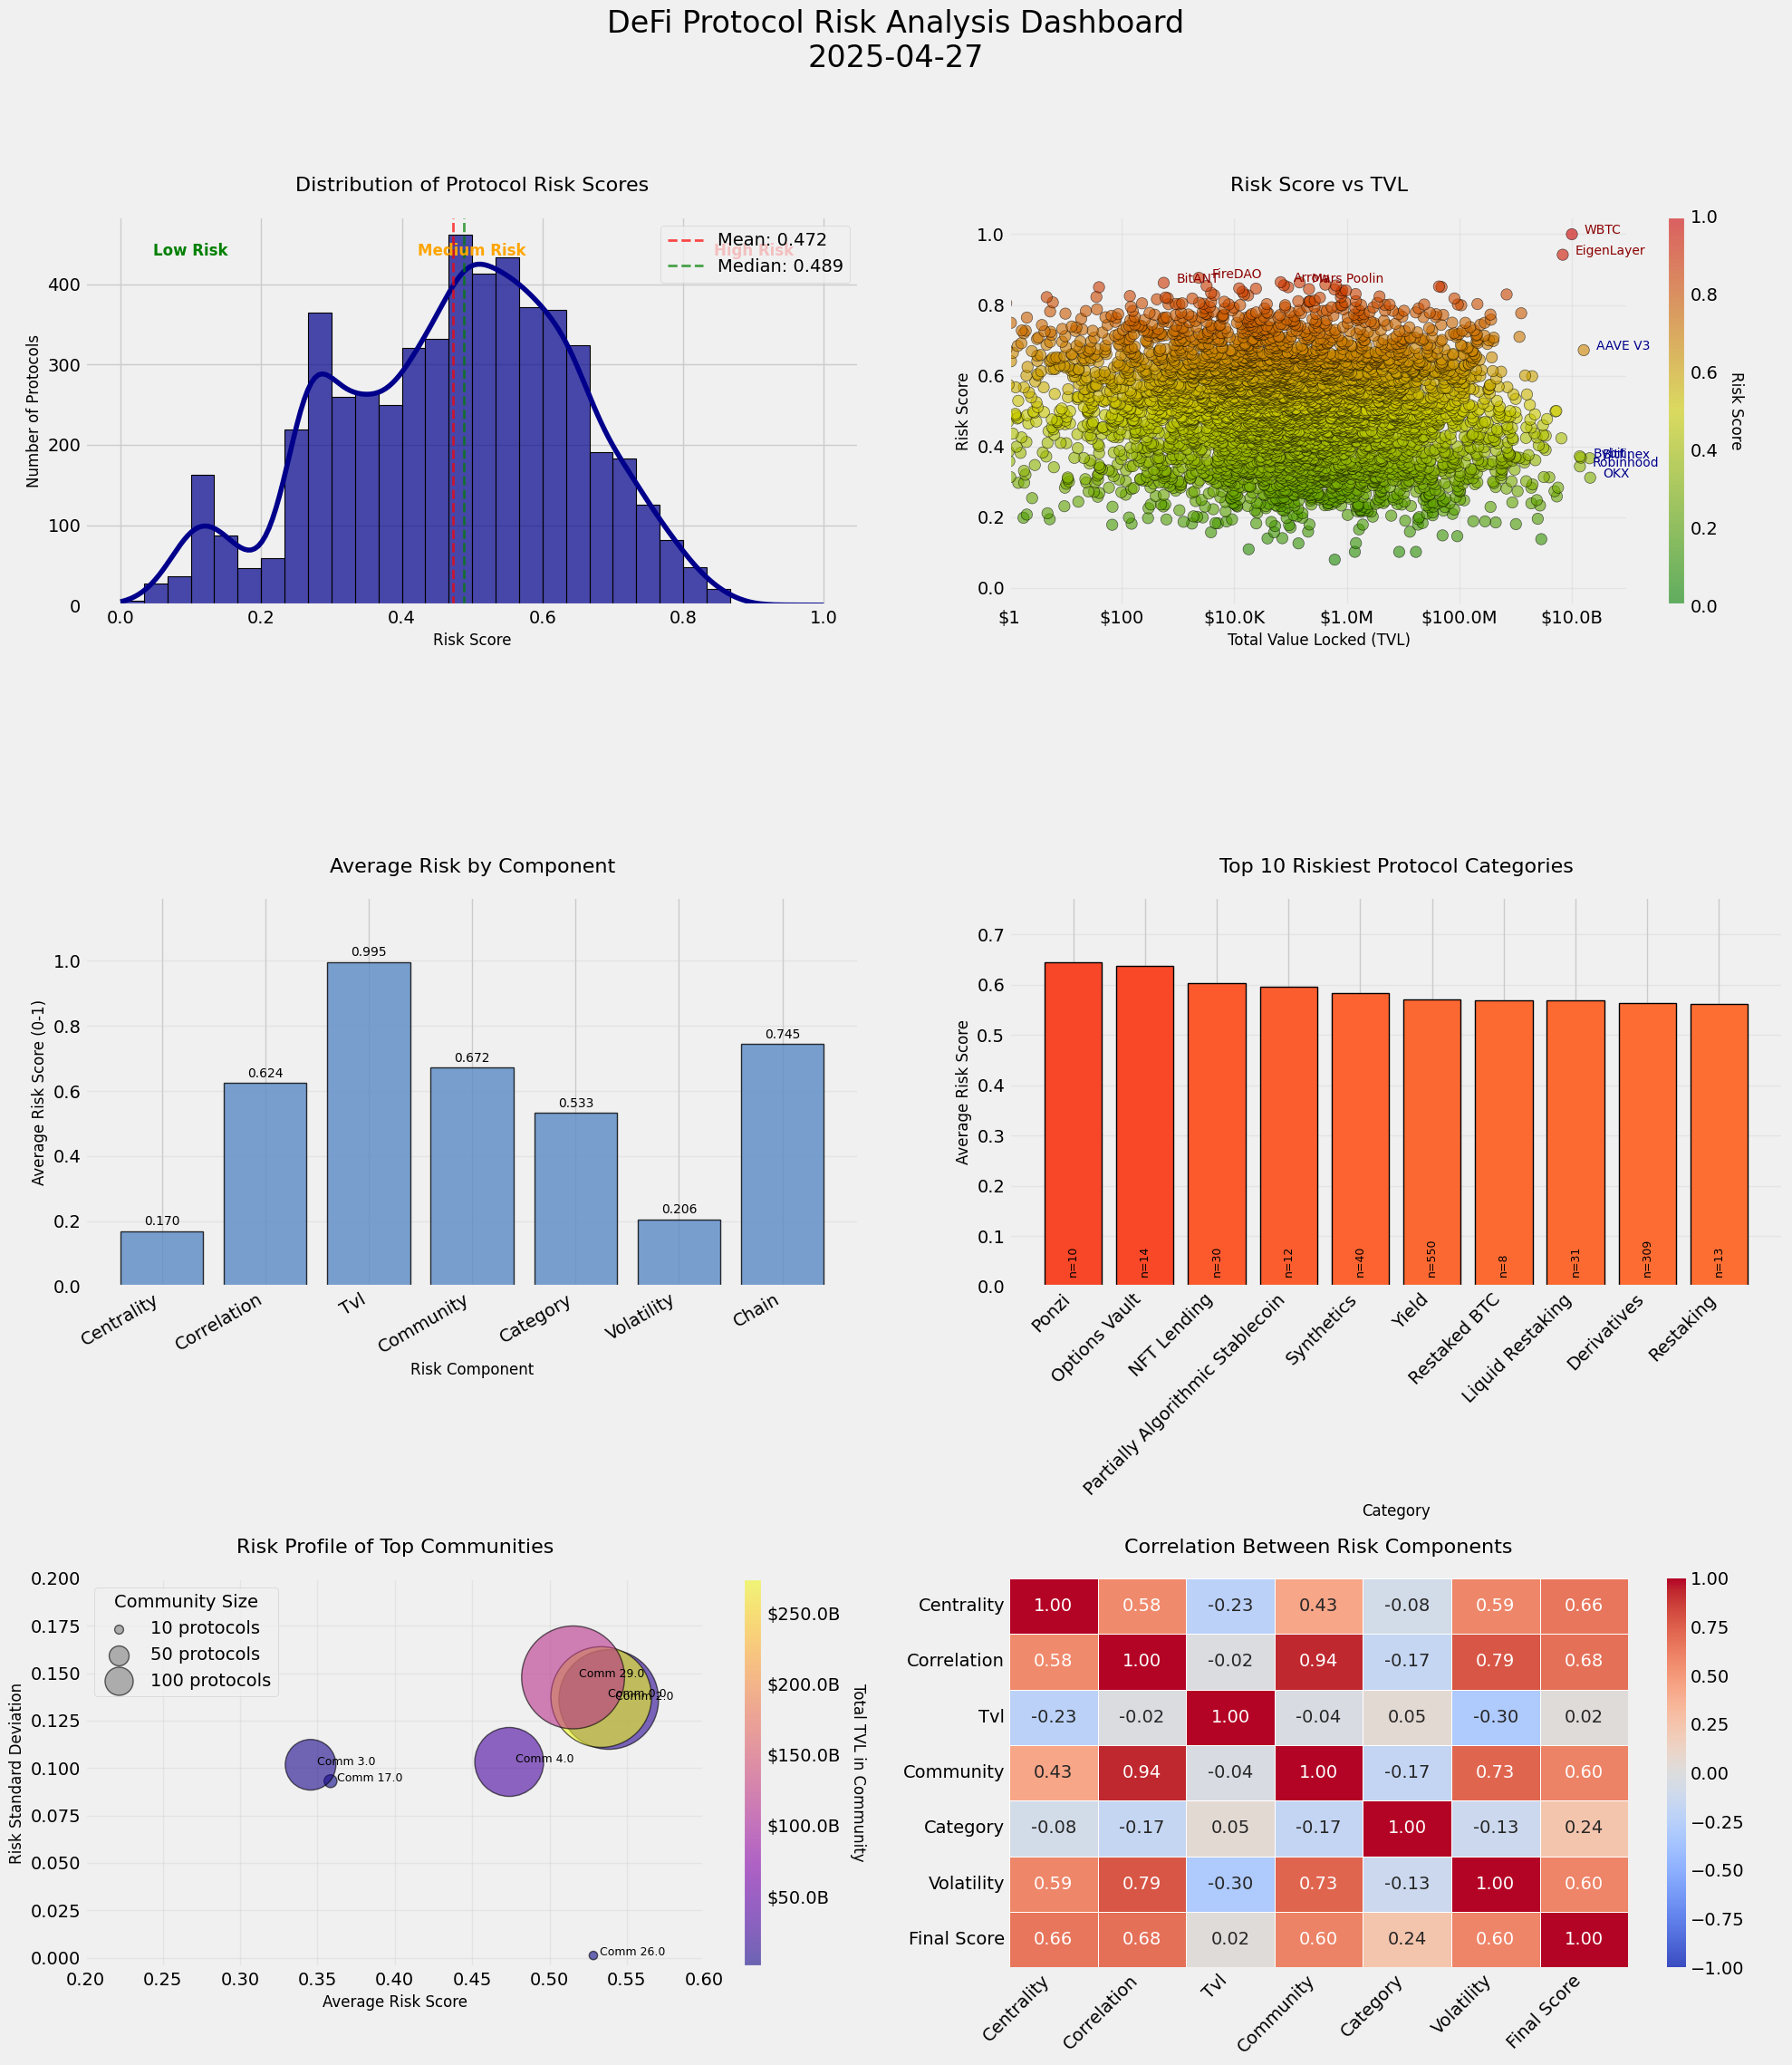

In [ ]:
formatted_date = date.today().strftime("%Y-%m-%d")

# Set up visualization style
plt.style.use('fivethirtyeight')
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = (14, 8)

# Create a custom colormap for risk (green to yellow to red)
colors = [(0.0, 0.5, 0.0), (0.8, 0.8, 0.0), (0.8, 0.0, 0.0)]
cmap_risk = LinearSegmentedColormap.from_list('risk_cmap', colors, N=100)

def millions_formatter(x, pos):
    """Format y-axis values in millions with $"""
    if x >= 1e9:
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.1f}K'
    else:
        return f'${x:.0f}'

def create_risk_dashboard(risk_df, output_file=f"risk_analysis/defi_risk_insights_{formatted_date}.png"):
    """Create a comprehensive dashboard of risk insights"""

    # Filter out extreme outliers for better visualizations
    filtered_df = risk_df[risk_df['tvl'] < risk_df['tvl'].quantile(0.9999)]

    # Create a 3x2 subplot layout
    fig, axes = plt.subplots(3, 2, figsize=(20, 24))
    plt.subplots_adjust(hspace=0.3, wspace=0.3)

    # 1. Risk Score Distribution - Top Left
    ax = axes[0, 0]
    sns.histplot(risk_df['risk_score'], kde=True, bins=30, ax=ax,
                color='darkblue', alpha=0.7, edgecolor='black', linewidth=0.8)
    ax.set_title('Distribution of Protocol Risk Scores', fontsize=16, pad=20)
    ax.set_xlabel('Risk Score', fontsize=12)
    ax.set_ylabel('Number of Protocols', fontsize=12)

    # Add mean and median lines
    mean_risk = risk_df['risk_score'].mean()
    median_risk = risk_df['risk_score'].median()
    ax.axvline(mean_risk, color='red', linestyle='--', linewidth=2, alpha=0.7,
              label=f'Mean: {mean_risk:.3f}')
    ax.axvline(median_risk, color='green', linestyle='--', linewidth=2, alpha=0.7,
              label=f'Median: {median_risk:.3f}')

    # Add annotations for low, medium, high risk
    ax.text(0.1, ax.get_ylim()[1]*0.9, 'Low Risk',
            ha='center', color='green', fontsize=12, weight='bold')
    ax.text(0.5, ax.get_ylim()[1]*0.9, 'Medium Risk',
            ha='center', color='orange', fontsize=12, weight='bold')
    ax.text(0.9, ax.get_ylim()[1]*0.9, 'High Risk',
            ha='center', color='red', fontsize=12, weight='bold')
    ax.legend(loc='upper right')

    # 2. Risk vs TVL - Top Right
    ax = axes[0, 1]
    scatter = ax.scatter(filtered_df['tvl'], filtered_df['risk_score'],
              c=filtered_df['risk_score'], cmap=cmap_risk,
              alpha=0.6, s=80, edgecolor='black', linewidth=0.5)

    # Add a colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Risk Score', rotation=270, labelpad=20, fontsize=12)

    # Add annotations for high TVL but varying risk protocols
    top_tvl_protocols = filtered_df.nlargest(5, 'tvl')
    for _, row in top_tvl_protocols.iterrows():
        ax.annotate(row['protocol_name'],
                   xy=(row['tvl'], row['risk_score']),
                   xytext=(10, 0), textcoords='offset points',
                   fontsize=10, color='darkblue')

    # Add annotations for highest risk protocols
    top_risk_protocols = filtered_df.nlargest(6, 'risk_score')
    for _, row in top_risk_protocols.iterrows():
        ax.annotate(row['protocol_name'],
                   xy=(row['tvl'], row['risk_score']),
                   xytext=(10, 0), textcoords='offset points',
                   fontsize=10, color='darkred')

    ax.set_title('Risk Score vs TVL', fontsize=16, pad=20)
    ax.set_xlabel('Total Value Locked (TVL)', fontsize=12)
    ax.set_ylabel('Risk Score', fontsize=12)
    ax.set_xscale('log')
    ax.set_xlim(1, 1e11)  # 1 to 100B
    ax.xaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax.grid(True, alpha=0.3)

    # 3. Risk Components - Middle Left
    ax = axes[1, 0]
    risk_components = ['centrality_risk', 'correlation_risk', 'tvl_risk',
                       'community_risk', 'category_risk', 'volatility_risk', 'chain_conn_risk']
    avg_component_values = [risk_df[col].mean() for col in risk_components]

    # Clean up labels
    component_labels = [c.replace('_risk', '').capitalize().replace('_conn','') for c in risk_components]

    bars = ax.bar(component_labels, avg_component_values, color='#5A8AC6',
           edgecolor='black', linewidth=1, alpha=0.8)

    # Add value labels on the bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
               f'{height:.3f}', ha='center', va='bottom', fontsize=10)

    ax.set_title('Average Risk by Component', fontsize=16, pad=20)
    ax.set_xlabel('Risk Component', fontsize=12)
    ax.set_ylabel('Average Risk Score (0-1)', fontsize=12)
    ax.set_ylim(0, max(avg_component_values) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=30, ha='right')

    # 4. Top Risky Categories - Middle Right
    ax = axes[1, 1]
    category_risk = risk_df.groupby('category').agg({
        'risk_score': 'mean',
        'protocol_name': 'count'
    }).reset_index()
    category_risk.columns = ['Category', 'Avg Risk Score', 'Protocol Count']
    category_risk = category_risk[category_risk['Protocol Count'] >= 5]  # Filter for categories with at least 5 protocols
    category_risk = category_risk.sort_values('Avg Risk Score', ascending=False).head(10)

    # Create bars with color based on risk
    bars = ax.bar(category_risk['Category'], category_risk['Avg Risk Score'],
           color=plt.cm.YlOrRd(category_risk['Avg Risk Score']),
           edgecolor='black', linewidth=1)

    # Add protocol count as text
    for i, bar in enumerate(bars):
        count = category_risk['Protocol Count'].iloc[i]
        ax.text(bar.get_x() + bar.get_width()/2., 0.02,
               f'n={count}', ha='center', va='bottom',
               color='black', fontsize=9, rotation=90)

    ax.set_title('Top 10 Riskiest Protocol Categories', fontsize=16, pad=20)
    ax.set_xlabel('Category', fontsize=12)
    ax.set_ylabel('Average Risk Score', fontsize=12)
    ax.set_ylim(0, max(category_risk['Avg Risk Score']) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')

    # 5. Risk by Community - Bottom Left
    ax = axes[2, 0]
    # Filter for communities with at least 10 protocols
    community_risk = risk_df.groupby('community_id').agg({
        'risk_score': ['mean', 'std'],
        'protocol_name': 'count',
        'tvl': 'sum'
    }).reset_index()
    community_risk.columns = ['Community', 'Avg Risk', 'Risk StdDev', 'Protocol Count', 'Total TVL']
    community_risk = community_risk[community_risk['Protocol Count'] >= 5]

    # Sort by average risk
    top_communities = community_risk.sort_values('Avg Risk', ascending=False).head(10)

    # Create scatter plot of communities
    scatter = ax.scatter(top_communities['Avg Risk'], top_communities['Risk StdDev'],
              s=top_communities['Protocol Count']*5, # Size based on protocol count
              c=top_communities['Total TVL'], cmap='plasma', # Color based on TVL
              alpha=0.6, edgecolor='black', linewidth=1)

    # Add community labels
    for i, row in top_communities.iterrows():
        ax.annotate(f"Comm {row['Community']}",
                   xy=(row['Avg Risk'], row['Risk StdDev']),
                   xytext=(5, 0), textcoords='offset points',
                   fontsize=9)

    ax.set_title('Risk Profile of Top Communities', fontsize=16, pad=20)
    ax.set_ylim(-0.005, 0.2)
    ax.set_xlim(0.2, 0.6)
    ax.set_xlabel('Average Risk Score', fontsize=12)
    ax.set_ylabel('Risk Standard Deviation', fontsize=12)

    # Add colorbar for TVL
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Total TVL in Community', rotation=270, labelpad=20, fontsize=12)
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

    # Add a legend for bubble size
    sizes = [10, 50, 100]
    for size in sizes:
        ax.scatter([], [], s=size*5, c='gray', alpha=0.6,
                  edgecolor='black', linewidth=1,
                  label=f'{size} protocols')
    ax.legend(title='Community Size', loc='upper left')
    ax.grid(True, alpha=0.3)

    # 6. Risk Component Correlation Heatmap - Bottom Right
    ax = axes[2, 1]
    risk_components = ['centrality_risk', 'correlation_risk', 'tvl_risk',
                      'community_risk', 'category_risk', 'volatility_risk', 'risk_score']
    component_labels = [c.replace('_risk', '').capitalize() for c in risk_components]
    component_labels[-1] = 'Final Score'

    corr_matrix = risk_df[risk_components].corr()

    # Plot heatmap
    heatmap = sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f',
                     linewidths=.5, vmin=-1, vmax=1, center=0,
                     xticklabels=component_labels, yticklabels=component_labels,
                     ax=ax)

    ax.set_title('Correlation Between Risk Components', fontsize=16, pad=20)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45, ha='right')
    plt.setp(ax.yaxis.get_majorticklabels(), rotation=0)

    # Dashboard title
    plt.suptitle(f'DeFi Protocol Risk Analysis Dashboard\n2025-04-27',
                fontsize=24, y=0.98)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    print(f"Risk insights dashboard saved to {output_file}")
    return fig


# Generate the dashboard
fig = create_risk_dashboard(risk_df)

# Show top insights as text summary
print("\n===== KEY RISK INSIGHTS =====")

# 1. Overall risk landscape
print(f"\n1. OVERALL RISK LANDSCAPE:")
print(f"   - Average risk score: {risk_df['risk_score'].mean():.4f}")
print(f"   - Median risk score: {risk_df['risk_score'].median():.4f}")
print(f"   - Standard deviation: {risk_df['risk_score'].std():.4f}")
print(f"   - {len(risk_df[risk_df['risk_score'] > 0.75])} protocols ({(len(risk_df[risk_df['risk_score'] > 0.75])/len(risk_df)*100):.1f}%) classified as high risk (>0.75)")

# 2. TVL concentration in risky protocols
high_risk = risk_df[risk_df['risk_score'] > 0.7]
high_risk_tvl = high_risk['tvl'].sum()
total_tvl = risk_df['tvl'].sum()
print(f"\n2. TVL CONCENTRATION IN RISKY PROTOCOLS:")
print(f"   - {len(high_risk)} high-risk protocols (score > 0.7) hold ${high_risk_tvl/1e9:.2f}B in TVL")
print(f"   - This represents {(high_risk_tvl/total_tvl*100):.1f}% of total TVL in the ecosystem")

# 3. Most concerning risk components
component_means = {comp: risk_df[comp].mean() for comp in ['centrality_risk', 'correlation_risk', 'tvl_risk',
                   'community_risk', 'category_risk', 'volatility_risk']}
highest_component = max(component_means.items(), key=lambda x: x[1])
print(f"\n3. MOST CONCERNING RISK COMPONENTS:")
print(f"   - {highest_component[0].replace('_risk', '').capitalize()} is the highest average risk factor ({highest_component[1]:.4f})")
for comp, mean in sorted(component_means.items(), key=lambda x: x[1], reverse=True):
    print(f"   - {comp.replace('_risk', '').capitalize()}: {mean:.4f}")

# 4. Risky categories
category_risk = risk_df.groupby('category').agg({
    'risk_score': 'mean',
    'protocol_name': 'count',
    'tvl': 'sum'
}).sort_values('risk_score', ascending=False)

print(f"\n4. RISKIEST PROTOCOL CATEGORIES:")
for i, (idx, row) in enumerate(category_risk.head(5).iterrows(), 1):
    if row['protocol_name'] >= 5:  # Only show categories with at least 5 protocols
        tvl = millions_formatter(row['tvl'], '')
        print(f"   {i}. {idx}: {row['risk_score']:.4f} avg risk across {row['protocol_name']} protocols, {tvl} TVL")

# 5. Risk-TVL correlation
tvl_risk_corr = risk_df['tvl'].corr(risk_df['risk_score'])
print(f"\n5. RELATIONSHIP BETWEEN TVL AND RISK:")
print(f"   - Correlation between TVL and risk score: {tvl_risk_corr:.4f}")
if abs(tvl_risk_corr) > 0.3:
    relationship = "strong positive" if tvl_risk_corr > 0 else "strong negative"
    print(f"   - There is a {relationship} relationship between protocol size and risk")
else:
    print(f"   - No strong relationship detected between protocol size and risk")